# Fit exponentials to Cell 5 from Kylie

All the data files are in my OneDrive at: /OneDrive .../Postdoc/cardiacNoiseData, but I'll add some of the data here in folder Some_Kilies_data/
There is a readme.txt file explaining what is in each file, including the names of the protocols and a dictionary of cell's names.  Protocols 3-5 are big files to have in github. Protocl 7 is the sine wave data, and protocol 6 is the action potential data. I'll start with one of the smaller data sets.

The protocols that I have the myokit version are 2, 3, 4, 5

To do:
- Code an exponential approximation <- DONE
- load data
- minimize residuals



In [2]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import myokit
import myokit.lib.markov
#from scipy.interpolate import interp1d,  UnivariateSpline, splrep, splev, make_lsq_spline, BSpline
from scipy.optimize import minimize#, curve_fit
import cma
from sklearn.linear_model import LinearRegression

In [3]:
def SRexpo_spline(params, times, deltat, data, expo_4):
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    
    residuals = expo_splines - data
    return sum(residuals**2)

def SRexpo_spline_weight(params, times, deltat, data, expo_4):
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    #weight = np.exp(-(times-deltat)) / sum(np.exp(-(times-deltat)))
    weight =  1 / (1 + 9 * ((times - deltat)>10) + 90 * ((times - deltat)>100) +  900 * ((times - deltat)>1000))
    residuals = (expo_splines - data) 
    return sum((residuals**2) * weight)

def expo_spline(times, deltat, params, expo_4):
    # three_expo = flag to calculate 2 or 3 exponentials. Default == False. If true, we'll be fitting sum of 3 expo
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    return expo_splines

## A meta parameter

All the jump voltages have a time at the beggining that we will remove. We'll remove 50ms 
times_to_skip = 50 

In [4]:
times_to_skip = 50 

## Focus on one protocol first

Start with protocol 3, cell 5

To do:
- divide wrt constant V intervals
- investigate the spline interpolation
- get splines per interval
- get residuals
- ploy residuals vs 1. Current, 2. Voltage, 3. time

## Separate by V level

The current and time is partitinonated to a level of V

In [5]:
# Load the data
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)

# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')
# Load a protocols
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')


# Define the steps of the protocol
pr3_Vtimes = (np.array(protocol_3.log_for_interval(0,pr3_time[-1] + 0.1)['time'])*10)
pr3_Vtimes = pr3_Vtimes.astype(np.int32)

pr3_current_constV = {}
pr3_current_constV_without_first5ms = {}
pr3_time_constV_without_first5ms = {}
for i in range(len(pr3_Vtimes)-1):
    pr3_current_constV[i]= pr3_current[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)]
    pr3_current_constV_without_first5ms[i] = pr3_current[pr3_Vtimes[i]+times_to_skip:(pr3_Vtimes[i+1]-1)]
    pr3_time_constV_without_first5ms[i] = pr3_time[pr3_Vtimes[i]+times_to_skip:(pr3_Vtimes[i+1]-1)]
print(len(pr3_current_constV))


42


## Define color scheme by V's

There are 9 unique V's. (-120, -80:20:60), So I need 9 unique colors. 

In [6]:
# Voltages
pr3_voltage_constV = pr3_voltage[pr3_Vtimes[:-1]]
pr3_unique_Vs, pr3_unique_Vs_1stUindex, pr3_unique_Vs_index= np.unique(pr3_voltage_constV, return_index = True, return_inverse = True)

# Colors & labels long
#pr3_unique_Vs_colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9']
#pr3_unique_Vs_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999']
pr3_unique_Vs_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
pr3_voltage_constV_colors = []
pr3_voltage_constV_labels_full = []
for i in range(len(pr3_unique_Vs_index)):
    pr3_voltage_constV_colors.append(pr3_unique_Vs_colors[pr3_unique_Vs_index[i]])
    pr3_voltage_constV_labels_full.append('V ='+str(pr3_unique_Vs[pr3_unique_Vs_index[i]]))

# Labels simple
pr3_voltage_constV_labels_simple = np.repeat('_nolegend_', len(pr3_unique_Vs_index))
for i in range(len(pr3_unique_Vs_1stUindex)):
    pr3_voltage_constV_labels_simple[pr3_unique_Vs_1stUindex[i]] = 'V ='+str(pr3_unique_Vs[i])


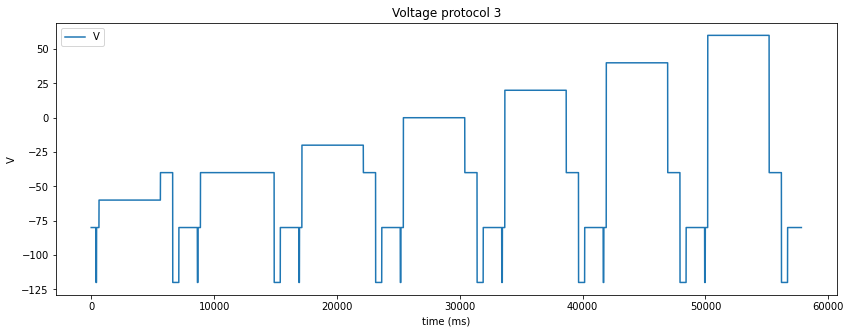

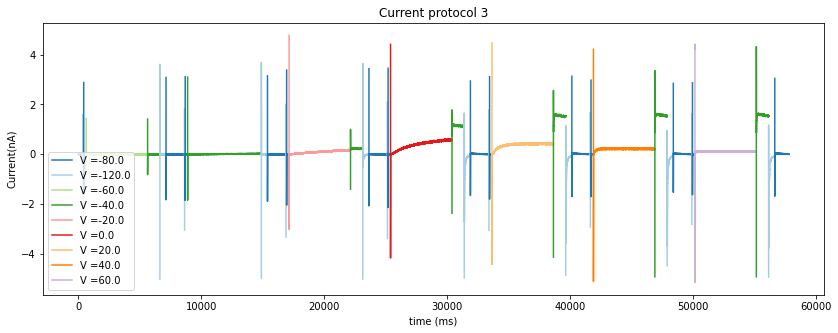

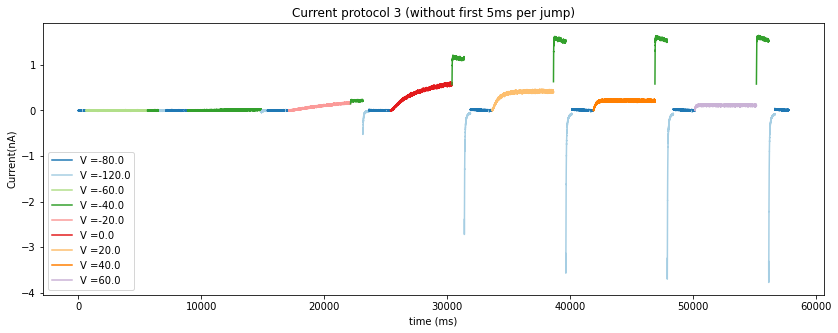

In [7]:
plt.figure(figsize=(14, 5))
plt.plot(pr3_time, pr3_voltage,'-', label='V')
plt.xlabel('time (ms)')
plt.ylabel('V')
plt.title('Voltage protocol 3')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(14, 5))
for i in range(len(pr3_Vtimes)-1):
    plt.plot(pr3_time[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)], pr3_current_constV[i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3')
plt.legend(loc='lower left')
plt.show()

plt.figure(figsize=(14, 5))
#plt.plot(pr3_time,pr3_current,':', label = 'Full current')
for i in range(len(pr3_Vtimes)-1):
    plt.plot(pr3_time_constV_without_first5ms[i], pr3_current_constV_without_first5ms[i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3 (without first 5ms per jump)')
plt.legend(loc='lower left')
plt.show()



## Estimate epsilon from V = -80

- load data for V=-80
- take residuals ? 
    - does it makes sense or is it directly take values since the mean current is zero?
- Get R^2 by batch and mean
- Get the mean of the R^2

15


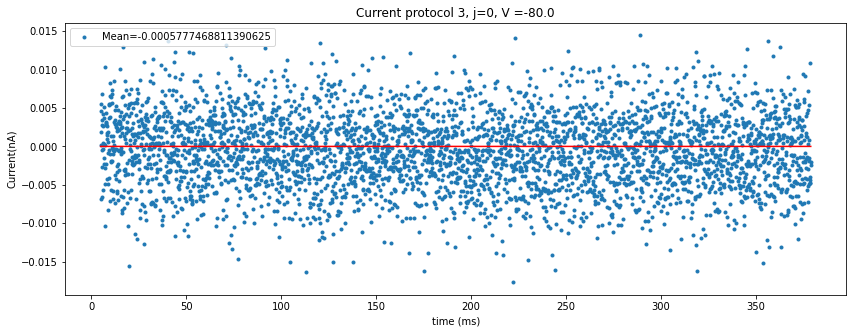

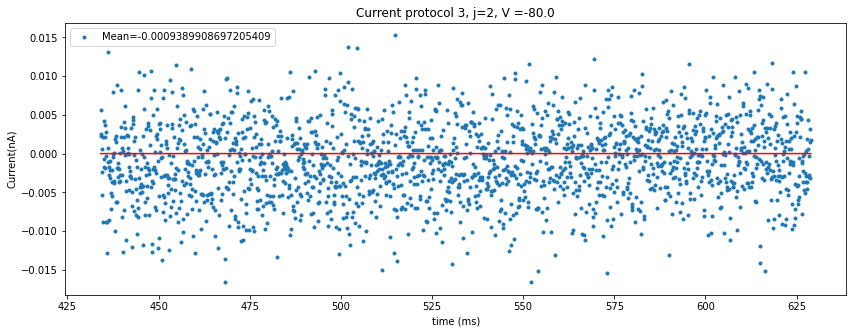

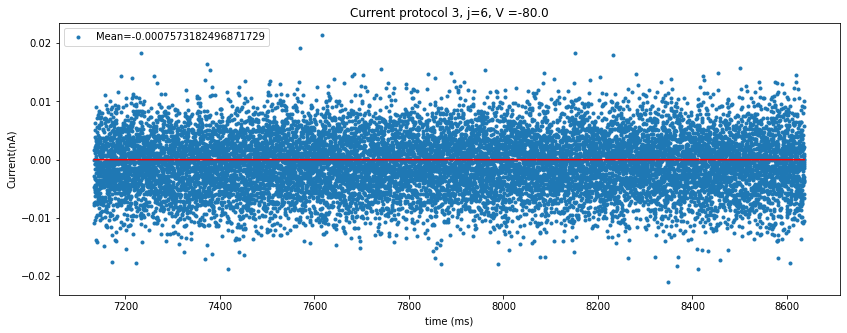

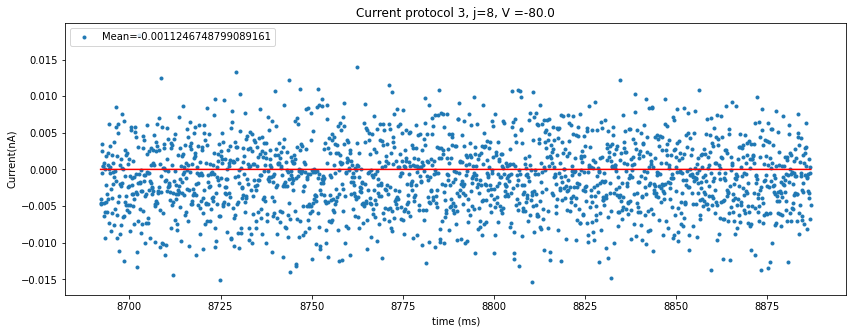

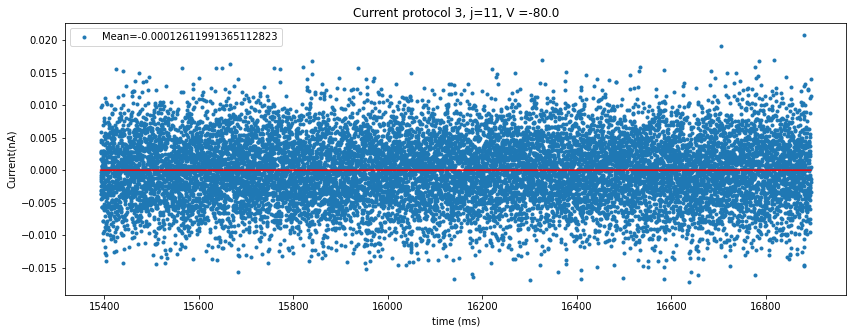

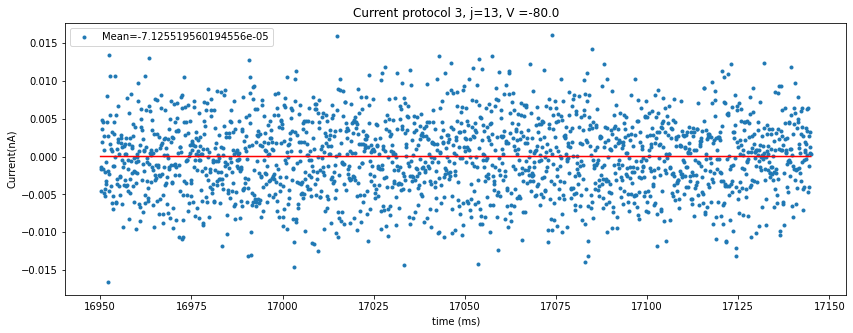

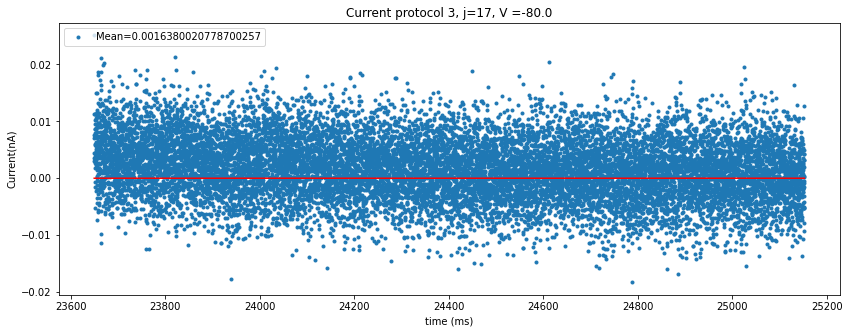

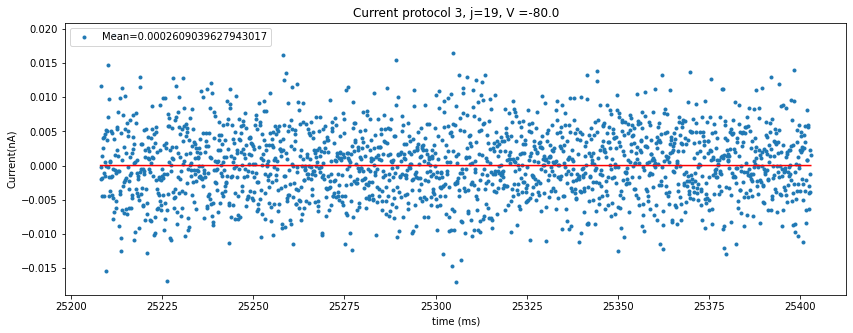

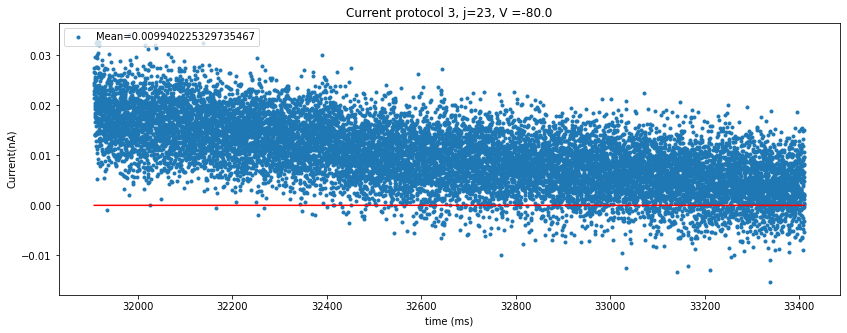

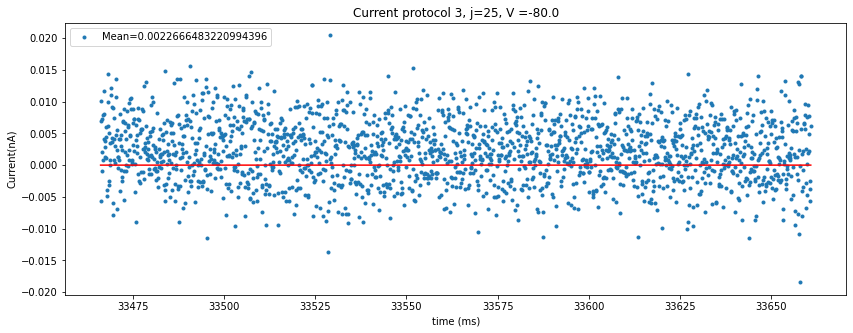

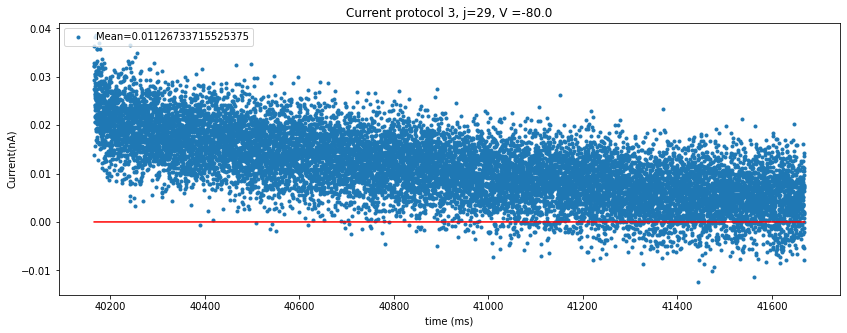

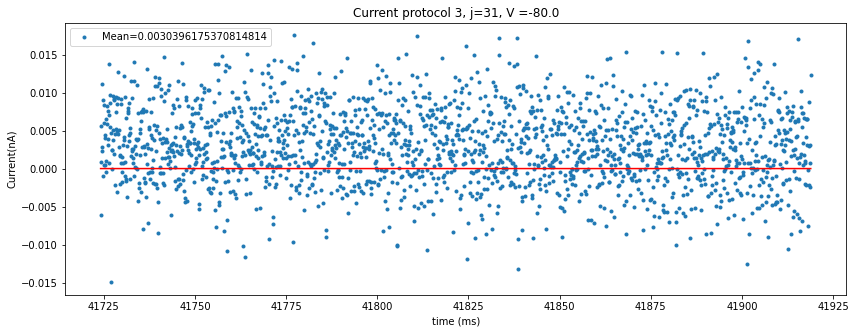

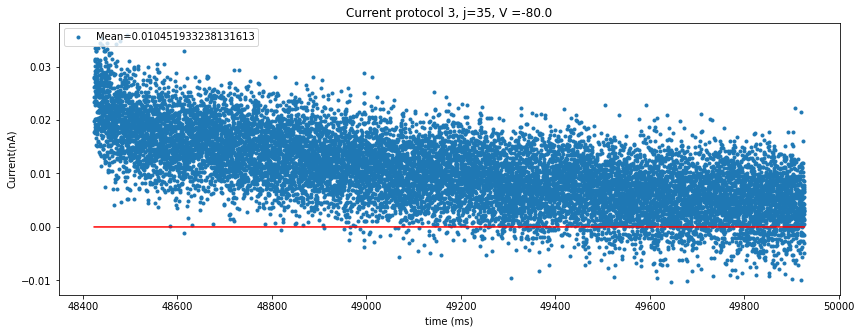

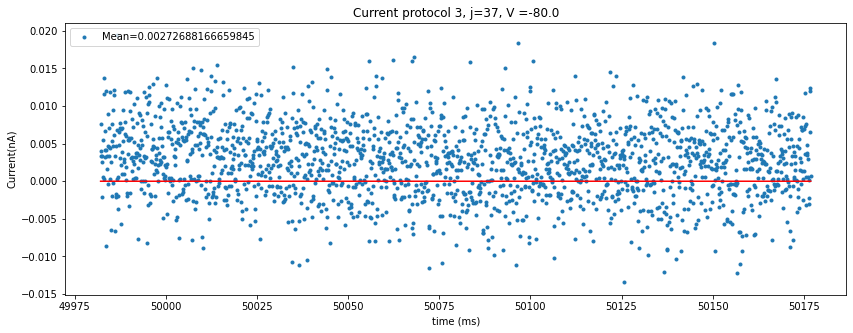

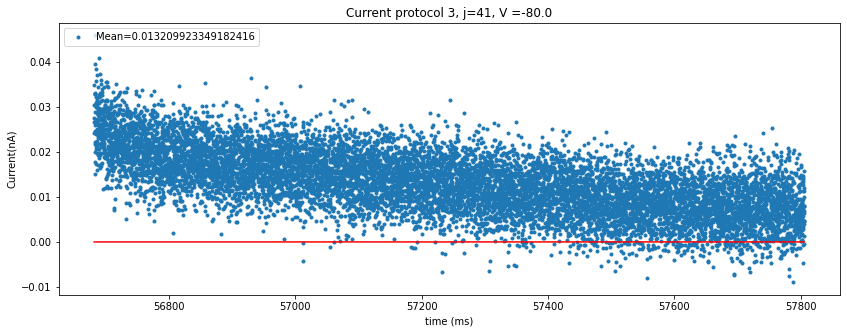

In [8]:
# Find where V = -80
print(sum(pr3_voltage_constV==-80))
index_neg80 = np.nonzero(pr3_voltage_constV==-80)
index_neg80 = index_neg80[0]
index_neg80_meanzero = []
V80_means = np.zeros(len(index_neg80))
V80_vars = np.zeros(len(index_neg80))


#pr3_current_constV_all80s =np.array([])
pr3_current_constV_80smeanzero =np.array([])

for k in range(len(index_neg80)):
    j = index_neg80[k]
    V80_means[k] = np.mean(pr3_current_constV_without_first5ms[j])
    V80_vars[k] = np.var(pr3_current_constV_without_first5ms[j])
    #pr3_current_constV_all80s = np.append(pr3_current_constV_all80s, pr3_current_constV[j][times_to_skip:])
    if np.abs(V80_means[k]) < 0.009:
        index_neg80_meanzero.append(j)
        pr3_current_constV_80smeanzero =np.append(pr3_current_constV_80smeanzero, pr3_current_constV_without_first5ms[j])
    plt.figure(figsize=(14, 5))
    plt.plot(pr3_time_constV_without_first5ms[j], pr3_current_constV_without_first5ms[j],'.', color = pr3_voltage_constV_colors[j], label='Mean='+str(np.mean(pr3_current_constV_without_first5ms[j])))
    plt.plot(pr3_time_constV_without_first5ms[j],np.zeros(len(pr3_time_constV_without_first5ms[j])), color = 'r')
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Current protocol 3, j=' + str(j) + ', '+ pr3_voltage_constV_labels_full[j])
    plt.legend(loc='upper left')
    
plt.show()


In [9]:
print(index_neg80_meanzero)
#print(V80_vars)
print('---- ALL V=-80 -------- V=-80 AND |mean|<0.009---')
print('Mean of means by jump:')
print([np.mean(V80_means), np.mean(V80_means[np.abs(V80_means)<0.009])])
print('Mean of all the time steps together:')
print([0, np.mean(pr3_current_constV_80smeanzero)])


print('Mean of Vars per jump:')
#print(V80_vars[np.abs(V80_means)<0.009])
epsilonA = np.mean(V80_vars)
epsilonB = np.mean(V80_vars[np.abs(V80_means)<0.009])
print([epsilonA, epsilonB])


print('Var of all the time steps together:')
epsilon1 = np.var(pr3_current_constV_80smeanzero)
print([0, epsilon1])



[0, 2, 6, 8, 11, 13, 17, 19, 25, 31, 37]
---- ALL V=-80 -------- V=-80 AND |mean|<0.009---
Mean of means by jump:
[0.0034136911099358785, 0.0005759952342486302]
Mean of all the time steps together:
[0, 0.0003391021796864299]
Mean of Vars per jump:
[3.0527468270471126e-05, 2.4792563496821662e-05]
Var of all the time steps together:
[0, 2.702548900276314e-05]


# Leak current

I'll check the transition between V=-80 to V=-120 to check if the leak current has been removed from the data set. 

For protocol 3, we always have the sequence of Vs: 40, -120, -80, -120, -80. And I'm interested in the -80,-120, -80 part. 

[ 0  2  6  8 11 13 17 19 23 25 29 31 35 37]
[ 0  6 11 17 23 29 35]


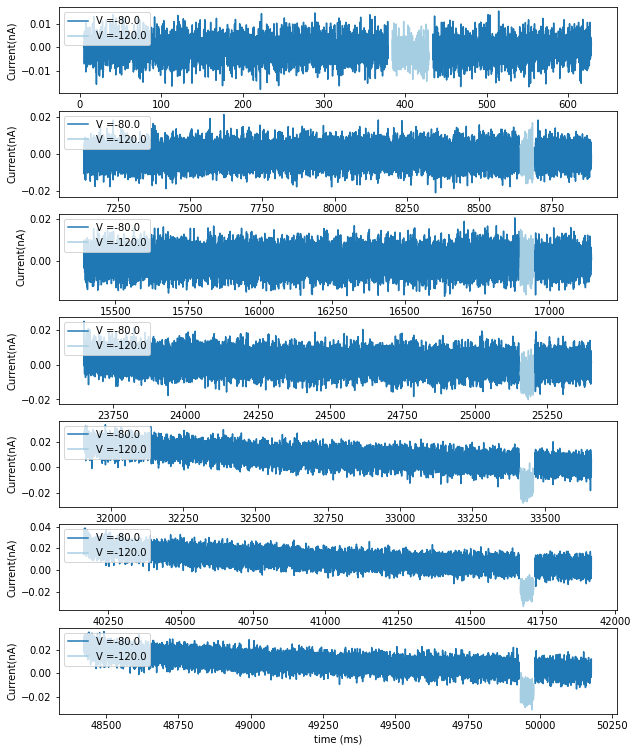

In [10]:

index_leak80 = np.nonzero(pr3_voltage_constV[:-2]==-80)
index_leak80 = index_leak80[0]
index_leak120 = np.nonzero(pr3_voltage_constV[index_leak80+1]==-120)
index_leak120 = index_leak120[0]
print(index_leak80)
print(index_leak80[index_leak120])

index_leak = index_leak80[index_leak120] # Index for the -80 to start the -80,-120,-80 jump. 


fig, axs = plt.subplots(len(index_leak),1, figsize=(10, 13))
axs = axs.ravel()

for k in range(len(index_leak)):
    j = index_leak[k]
    
    axs[k].plot(pr3_time_constV_without_first5ms[j], pr3_current_constV_without_first5ms[j], color = pr3_voltage_constV_colors[j], label=pr3_voltage_constV_labels_full[j])
    axs[k].plot(pr3_time_constV_without_first5ms[j+1], pr3_current_constV_without_first5ms[j+1], color = pr3_voltage_constV_colors[j+1], label=pr3_voltage_constV_labels_full[j+1])
    axs[k].plot(pr3_time_constV_without_first5ms[j+2], pr3_current_constV_without_first5ms[j+2], color = pr3_voltage_constV_colors[j+2], label='_nolegend_')
    axs[k].set_ylabel('Current(nA)')
    axs[k].legend(loc='upper left')
axs[k].set_xlabel('time (ms)')

plt.show()

## Voltage larger or equal than -40


In [20]:
print(pr3_voltage_constV[:-1]>=-40)

index_largerCurrents = np.nonzero(pr3_voltage_constV[:-1]>=-40)

index_largerCurrents = index_largerCurrents[0]
print(len(index_largerCurrents))

splines_largerCurrents = [None] * len(index_largerCurrents)
splines_params_largerCurrents = [None] * len(index_largerCurrents)
residuals2_largerCurrents = [None] * len(index_largerCurrents)
times_largerCurrents = [None] * len(index_largerCurrents)
currents_largerCurrents = [None] * len(index_largerCurrents)
deltat_largerCurrents = np.zeros(len(index_largerCurrents))


splines_largerCurrents_weights = [None] * len(index_largerCurrents)
splines_params_largerCurrents_weights= [None] * len(index_largerCurrents)
residuals2_largerCurrents_weights = [None] * len(index_largerCurrents)

# Separate times and currents:

for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i]
    times_largerCurrents[index_i] = pr3_time_constV_without_first5ms[i]
    currents_largerCurrents[index_i] = pr3_current_constV_without_first5ms[i]
    deltat_largerCurrents[index_i] =  times_largerCurrents[index_i][0]


[False False False False  True False False False False  True False False
 False False  True  True False False False False  True  True False False
 False False  True  True False False False False  True  True False False
 False False  True  True False]
12


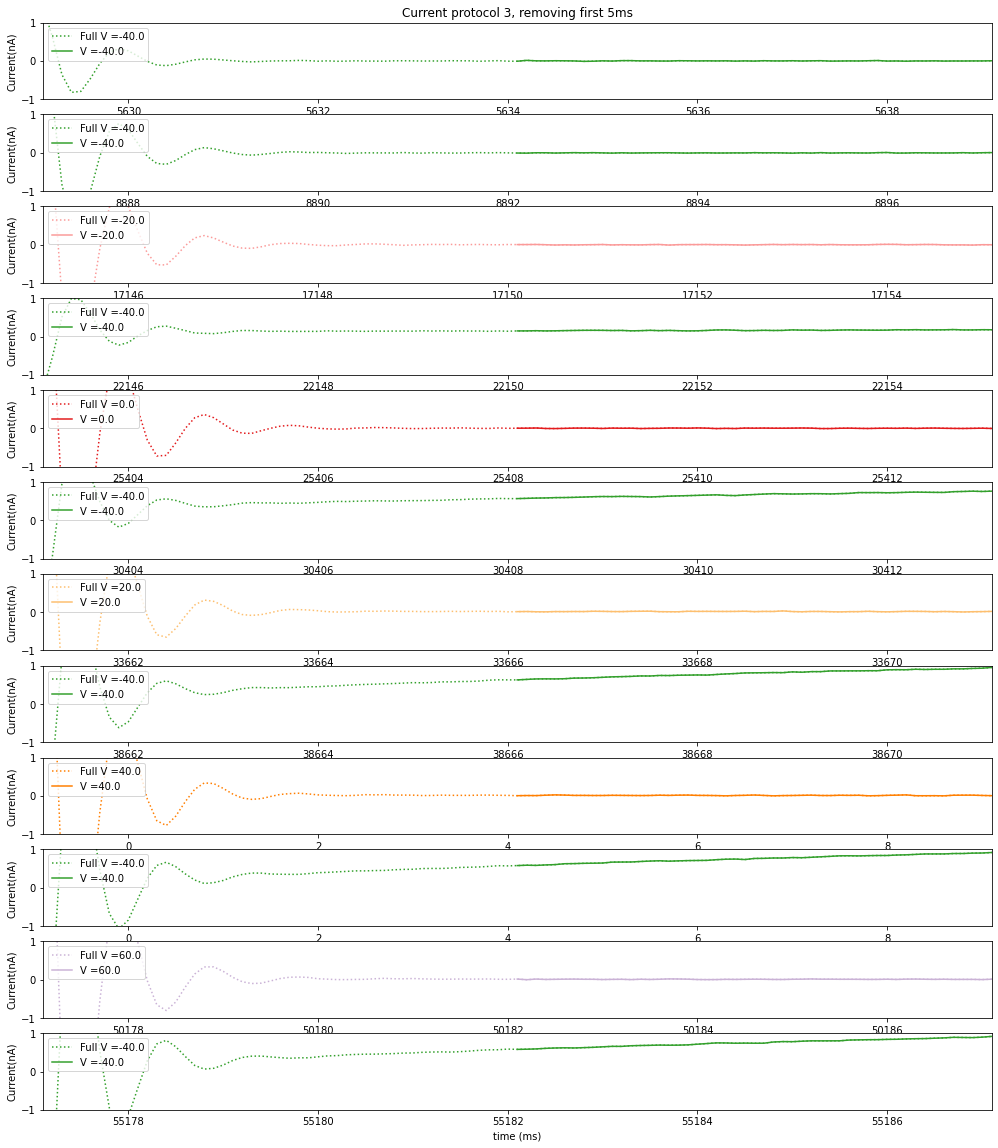

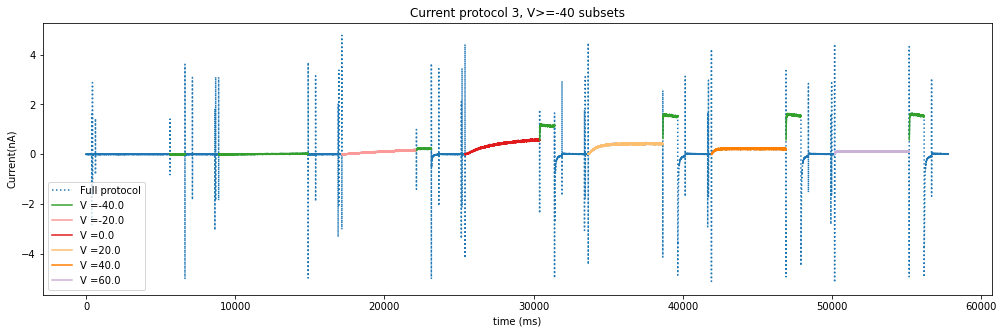

In [12]:

fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 20))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    axs[index_i].plot(pr3_time[(pr3_Vtimes[i]):(pr3_Vtimes[i+1]-1)], pr3_current_constV[i],':',color = pr3_voltage_constV_colors[i], label='Full ' + pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylim([-1,1])
    axs[index_i].set_xlim([pr3_time[pr3_Vtimes[i]],pr3_time[pr3_Vtimes[i]]+10])
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, removing first 5ms')
axs[index_i].set_xlabel('time (ms)')
plt.show()



plt.figure(figsize=(17, 5))
plt.plot(pr3_time, pr3_current,':', label='Full protocol')
for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    plt.plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Current protocol 3, V>=-40 subsets')
    plt.legend(loc='lower left')
plt.show()


In [17]:
# We will use 4 exponentials

NumExpo_flag = True

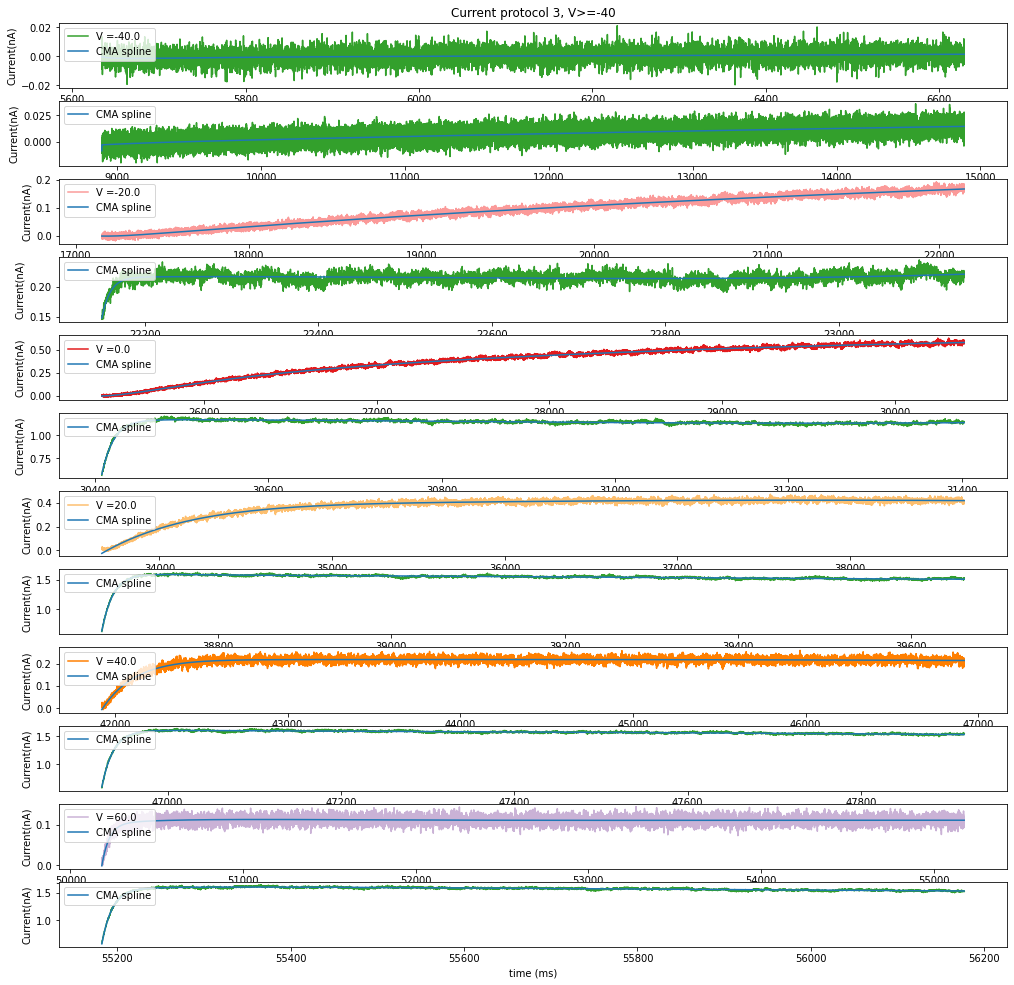

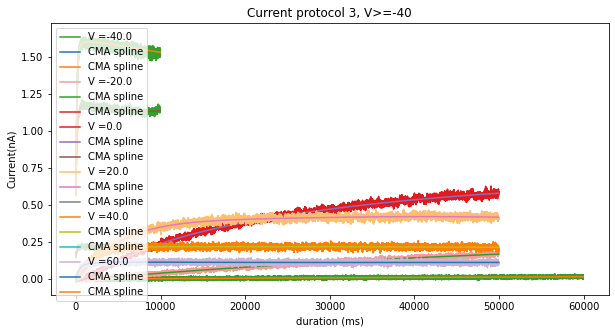

In [60]:
# SKIP THIS CELL IF THE PARAMETERS HAD BEEN SAVED
# CMA fit, NO weights. If paramerers had been save, skip this cell


for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    #Inital conditions and constrains:
    if NumExpo_flag:
        p0 = [currents_largerCurrents[index_i][-1], 0.01,times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0], 0.01,(times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0]), 0.01, (times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0])/2, 0.1,1]
        bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]
    else:
        p0 = [splines_largerCurrents[index_i][-1],splines_largerCurrents[index_i][-1] ,times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0] ,0.01 , times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0]]
        bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]

    optscma = cma.CMAOptions()
    optscma.set("bounds", bounds_cma)
    # CMA fit
    es = cma.fmin(SRexpo_spline, p0 , sigma0=1, args=[times_largerCurrents[index_i], deltat_largerCurrents[index_i], currents_largerCurrents[index_i], NumExpo_flag], options = optscma)
    splines_params_largerCurrents[index_i] = es[0]
    splines_largerCurrents[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents[index_i], NumExpo_flag)

# SAve the parameters of the spline:
np.save('protocol3_cell2_splines_params_largerCurrents.npy',np.array(splines_params_largerCurrents))

# Trying a better plot
fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 17))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Current(nA)')
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40')
axs[index_i].set_xlabel('time (ms)')
plt.show()


plt.figure(figsize=(10, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.plot(splines_largerCurrents[index_i], label = 'CMA spline')
plt.xlabel('duration (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, V>=-40')
plt.legend(loc='upper right')
plt.show()

In [21]:
# SKIP THIS CELL IF THIS IS THE FIRST TIME YOU RUN THE DATA
# Load the parameters of the spline:
splines_params_largerCurrents = np.load('protocol3_cell2_splines_params_largerCurrents.npy')


for index_i in range(len(index_largerCurrents)): 
    splines_largerCurrents[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents[index_i], NumExpo_flag)


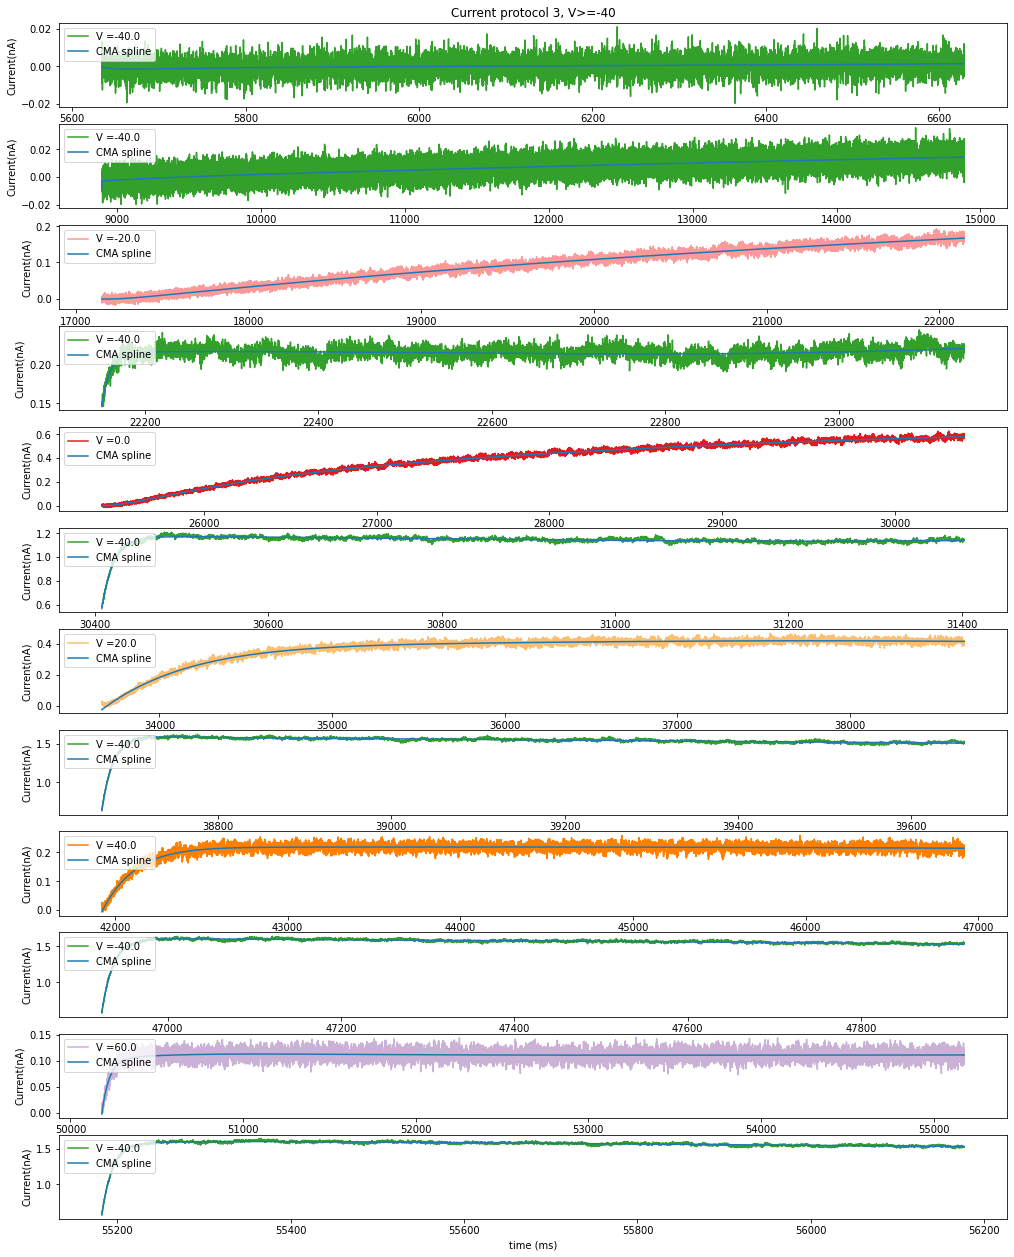

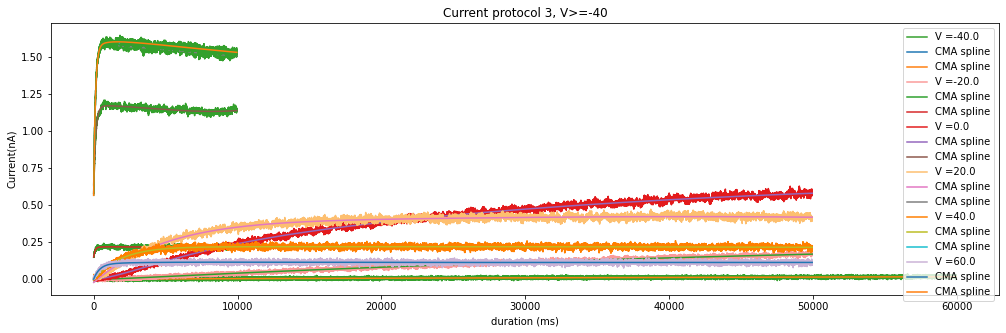

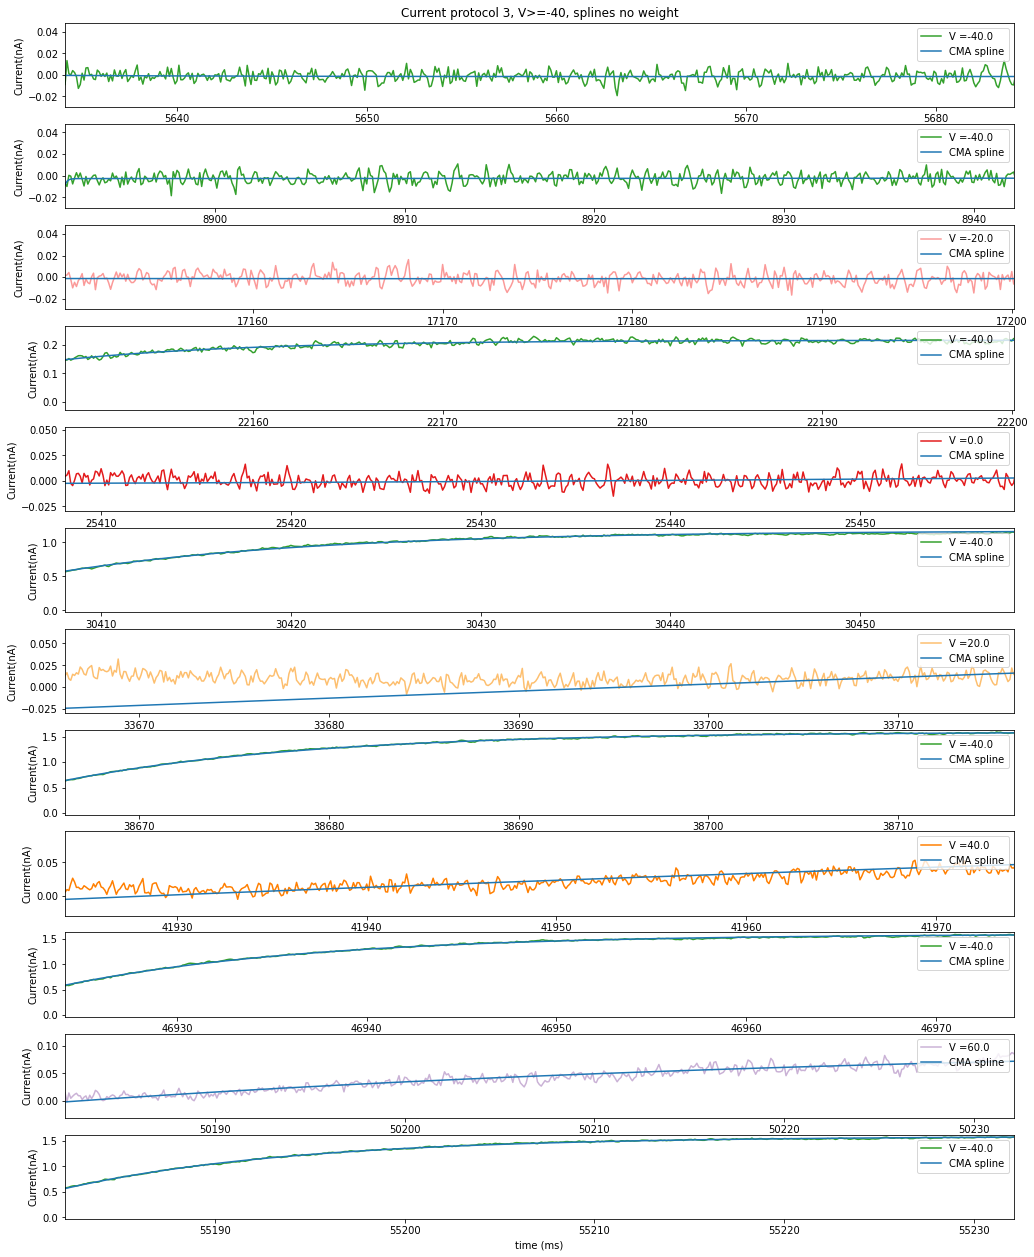

In [22]:
# Trying a better plot
fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Current(nA)')
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40')
axs[index_i].set_xlabel('time (ms)')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.plot(splines_largerCurrents[index_i], label = 'CMA spline')
plt.xlabel('duration (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, V>=-40')
plt.legend(loc='upper right')
plt.show()

# Zoom with no weights

fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper right')
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].set_xlim([times_largerCurrents[index_i][0],times_largerCurrents[index_i][0]+50])
    axs[index_i].set_ylim([-.03, splines_largerCurrents[index_i][500] + 0.05])
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40, splines no weight')
axs[index_i].set_xlabel('time (ms)')
plt.show()

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=552948, Sun Sep 12 19:27:00 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.631182467413116e+01 1.0e+00 8.61e-01  8e-01  9e-01 0:00.0
    2     20 8.648138886107763e+00 1.1e+00 7.99e-01  7e-01  8e-01 0:00.0
    3     30 9.492190910982588e+00 1.2e+00 7.09e-01  6e-01  7e-01 0:00.1
  100   1000 6.449838614701688e-03 8.3e+01 2.44e-02  5e-03  4e-02 0:01.8
  200   2000 6.364539707224585e-03 2.3e+03 8.70e-04  2e-05  3e-03 0:03.3
  300   3000 6.364112133465960e-03 4.6e+04 1.64e-03  5e-06  1e-02 0:04.8
  400   4000 6.363974199646172e-03 7.1e+04 2.34e-02  2e-05  1e-01 0:06.4
NOTE (module=cma, iteration=453):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.2e+10 to 1.2e+09
  500   5000 6.363723412098452e-03 4.0e+04 4.23e-02  1e-05  2e-01 0:08.0
  600   6000 6.363568012709611e-03 1.1e+05 1.32e-03  2e-07  9e-03 0:09.3
  620   6200 6.363568011465321e

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=520)
  warnings.warn(msg + ' (' +


  600   6000 8.351393499915335e-03 1.7e+01 2.18e-03  8e-04  2e-03 0:45.5
  625   6250 8.351393499454561e-03 3.4e+01 3.90e-04  9e-05  5e-04 0:47.5
termination on tolfun=1e-11 (Sun Sep 12 19:28:29 2021)
final/bestever f-value = 8.351393e-03 8.351393e-03
incumbent solution: [ 5.26510848e-02 -5.82820899e+01  5.94326538e+03  5.82924315e+01
  5.93418721e+03 -6.54107943e-02  3.02368083e+03 -1.61459383e-03 ...]
std deviations: [3.41210679e-04 3.53324439e-04 4.17885610e-04 2.92608078e-04
 2.74738285e-04 3.42304568e-04 5.10650345e-04 8.57366209e-05 ...]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=525858, Sun Sep 12 19:28:29 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.012607620233282e+02 1.0e+00 8.86e-01  8e-01  9e-01 0:00.1
    2     20 1.362965446992355e+01 1.2e+00 8.37e-01  8e-01  9e-01 0:00.1
    3     30 1.944146763168169e+01 1.3e+00 7.80e-01  7e-01  8e-01 0:00.2
   53    530 1.922484583024440e-01 2.0e+01 2.04e-01  1e-01  3e-01 0:

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.3e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1255)
  warnings.warn(msg + ' (' +


 1300  13000 1.005922424286049e-02 7.8e+00 1.52e+01  9e+00  2e+01 1:21.8
 1400  14000 1.005909702539131e-02 5.4e+01 3.84e-02  9e-03  5e-02 1:28.1
 1402  14020 1.005909702538351e-02 5.2e+01 3.25e-02  7e-03  4e-02 1:28.2
termination on tolfun=1e-11 (Sun Sep 12 19:30:59 2021)
final/bestever f-value = 1.005910e-02 1.005910e-02
incumbent solution: [ 2.78707514e-01 -1.39670477e+00  3.89644457e+03  1.11038961e+00
  3.58856941e+03  7.38996432e-03  6.86245378e+01  2.26929240e-03 ...]
std deviations: [0.02579166 0.02235093 0.04002096 0.02590479 0.03478741 0.02076261
 0.00798889 0.00682582 ...]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=593750, Sun Sep 12 19:30:59 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.589108638422183e+01 1.0e+00 8.71e-01  8e-01  9e-01 0:00.0
    2     20 3.252913652699711e+01 1.1e+00 8.20e-01  8e-01  8e-01 0:00.0
    3     30 1.005503003889455e+01 1.2e+00 7.74e-01  7e-01  8e-01 0:00.0
  100   1000 5.137207360541

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=611)
  warnings.warn(msg + ' (' +


  700   7000 1.222183030700577e-02 3.7e+01 2.39e-01  2e-01  6e-01 0:10.2
  800   8000 1.222132458630939e-02 2.1e+02 4.99e-01  3e-01  2e+00 0:11.6
  900   9000 1.222049640749046e-02 9.4e+02 1.31e+00  5e-01  5e+00 0:13.1
 1000  10000 1.221779803960578e-02 4.3e+03 7.60e+00  2e+00  4e+01 0:14.6
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 1.221472698361499e-02 8.5e+03 9.85e+00  3e+00  3e+01 0:16.2
 1200  12000 1.221193387479775e-02 1.8e+04 2.48e+01  8e+00  7e+01 0:17.8
 1300  13000 1.220941104555886e-02 9.0e+04 6.28e+01  1e+01  3e+02 0:19.3
 1400  14000 1.220754174196603e-02 5.5e+05 1.35e+02  1e+02  8e+02 0:21.0
 1417  14170 1.220718828803339e-02 6.0e+05 1.89e+02  2e+02  1e+03 0:21.3
termination on tolfacupx=1000.0 (Sun Sep 12 19:32:14 2021)
final/bestever f-value = 1.220718e-02 1.220718e-02
incumbent solution: [ 2.00676404e+01 -1.14061260e+04  4.21537055e+03  1.15848488e+04
  4.18374280e+03 -1.98574069e+02  3.14249285e+03 -6.75281888e-02 ...]
std de

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=935)
  warnings.warn(msg + ' (' +


 1000  10000 1.774665261294815e-02 1.5e+01 1.82e+01  1e+01  3e+01 1:07.0
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 1.772723366431510e-02 1.0e+02 1.30e+01  5e+00  2e+01 1:13.4
 1200  12000 1.772569295084616e-02 9.4e+02 6.21e+00  1e+00  1e+01 1:19.7
 1300  13000 1.772543866715578e-02 2.2e+03 1.97e+01  2e+00  3e+01 1:26.0
 1400  14000 1.772508357228529e-02 1.4e+03 3.76e+01  2e+00  3e+01 1:32.4
 1500  15000 1.772448794732435e-02 1.4e+03 1.16e+02  2e+00  7e+01 1:38.9
 1600  16000 1.772375313219702e-02 9.4e+02 2.58e+02  3e+00  8e+01 1:45.2
 1700  17000 1.772304996710020e-02 6.3e+02 3.43e+02  2e+00  4e+01 1:51.6
 1800  18000 1.772244242448209e-02 7.0e+02 6.57e+02  2e+00  3e+01 1:58.0
 1900  19000 1.772186595808088e-02 4.9e+02 2.17e+03  3e+00  4e+01 2:04.2
 2000  20000 1.772142823380721e-02 7.3e+02 2.71e+03  2e+00  2e+01 2:10.5
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 2100  21000 1.772113311672721e-02 7.8e+02 3.16e+03  

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=695)
  warnings.warn(msg + ' (' +


  700   7000 4.058525741360225e-02 1.4e+00 1.27e+00  1e+00  1e+00 0:10.1
  800   8000 4.055635282191161e-02 6.2e+01 3.32e+00  1e+00  8e+00 0:11.6
  900   9000 4.037263279520262e-02 3.1e+02 5.14e+00  1e+00  1e+01 0:13.1
 1000  10000 3.899223123732388e-02 6.7e+02 1.56e+01  4e+00  2e+01 0:14.6
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 3.710657779020516e-02 1.8e+03 4.32e+01  1e+01  7e+01 0:16.1
 1200  12000 3.699571322170318e-02 5.0e+03 1.91e+00  2e-01  3e+00 0:17.6
 1300  13000 3.698837920840321e-02 9.4e+03 2.38e+01  1e+00  2e+01 0:19.1
 1400  14000 3.696953988883717e-02 9.3e+03 1.12e+02  3e+00  5e+01 0:20.6
 1500  15000 3.695633760957132e-02 2.0e+04 7.02e+01  8e-01  3e+01 0:22.2
 1600  16000 3.695615791461927e-02 1.5e+05 2.28e+00  9e-03  1e+00 0:24.0
 1700  17000 3.695601275246537e-02 4.9e+06 7.48e+01  7e-01  9e+02 0:25.6
 1701  17010 3.695599042911850e-02 5.0e+06 8.28e+01  8e-01  1e+03 0:25.6
termination on tolfacupx=1000.0 (Sun Sep 12 19:59:07

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=832)
  warnings.warn(msg + ' (' +


  900   9000 2.376104422342908e-02 4.0e+01 6.44e-01  4e-01  6e+00 0:58.0
 1000  10000 2.376074010244186e-02 1.8e+02 2.27e+00  1e+00  2e+01 1:04.6
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 2.376005321747846e-02 8.0e+02 6.16e+00  1e+00  4e+01 1:11.1
 1200  12000 2.375891324471656e-02 6.4e+03 3.64e+01  1e+01  4e+02 1:17.7
 1300  13000 2.375804783872469e-02 7.2e+03 3.22e+01  6e+00  2e+02 1:24.3
 1400  14000 2.375756809797215e-02 9.8e+03 4.96e+01  8e+00  1e+02 1:30.9
 1500  15000 2.375714568217806e-02 1.8e+04 9.48e+01  1e+01  1e+02 1:37.5
 1600  16000 2.375681886342719e-02 6.2e+04 2.71e+02  4e+01  5e+02 1:44.2
 1649  16490 2.375663718268026e-02 1.2e+05 3.93e+02  5e+01  1e+03 1:47.6
termination on tolfacupx=1000.0 (Sun Sep 12 20:02:19 2021)
final/bestever f-value = 2.375663e-02 2.375662e-02
incumbent solution: [-1.81526405e+00  1.86448967e+04  1.98729677e+04 -1.86427174e+04
  1.98700292e+04 -4.16059071e-01  4.21780156e+02  6.91265003e-02 ...]
std de

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=510)
  warnings.warn(msg + ' (' +


  600   6000 3.403358065269665e-02 1.9e+02 1.13e-01  7e-02  4e-01 0:08.8
  700   7000 3.400340009465676e-02 7.3e+02 4.81e-01  2e-01  1e+00 0:10.3
  800   8000 3.399432577270069e-02 4.8e+02 7.24e-01  3e-01  9e-01 0:11.8
  900   9000 3.398683273346034e-02 7.6e+02 2.20e+00  5e-01  2e+00 0:13.2
 1000  10000 3.398221480232897e-02 1.8e+03 2.56e+00  2e-01  1e+00 0:14.7
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 3.397962769222466e-02 5.3e+03 3.85e+00  2e-01  2e+00 0:16.2
 1200  12000 3.397807358494850e-02 9.4e+03 6.57e+00  2e-01  2e+00 0:17.6
 1300  13000 3.397713034449538e-02 2.2e+04 8.68e+00  1e-01  2e+00 0:19.2
 1400  14000 3.397646360350243e-02 8.1e+04 1.33e+01  2e-01  3e+00 0:21.0
 1500  15000 3.397606212501196e-02 1.1e+05 2.42e+01  2e-01  4e+00 0:22.7
 1600  16000 3.397576049024279e-02 3.0e+05 5.73e+01  3e-01  7e+00 0:24.4
 1700  17000 3.397557747620217e-02 3.4e+05 7.07e+01  1e-01  5e+00 0:26.1
 1800  18000 3.397542429095632e-02 5.1e+05 1.19e+02 

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1728)
  warnings.warn(msg + ' (' +


 1739  17390 2.576419748574894e-02 1.9e+00 8.52e+02  7e+02  1e+03 1:55.3
termination on tolfacupx=1000.0 (Sun Sep 12 20:09:13 2021)
final/bestever f-value = 2.576425e-02 2.576420e-02
incumbent solution: [ 2.07954638e-01  6.41631552e-01  1.17838501e+03 -1.34392490e+00
  8.75744189e+02  2.11152853e+00  4.91886298e+02 -1.61399111e+00 ...]
std deviations: [ 693.07784343  748.20315366  866.58750388  800.59661681  824.44495286
  916.38936091  800.23355484 1019.36301523 ...]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=530397, Sun Sep 12 20:09:13 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 6.086300613941182e+01 1.0e+00 9.74e-01  1e+00  1e+00 0:00.0
    2     20 3.206457674219752e+01 1.2e+00 9.07e-01  9e-01  9e-01 0:00.0
    3     30 6.408015358279967e+01 1.3e+00 8.97e-01  8e-01  9e-01 0:00.1
  100   1000 5.550989789790579e-02 9.4e+01 2.01e-01  3e-02  5e-01 0:01.6
  200   2000 3.782468075448095e-02 1.0e+03 1.57e-03  4e-05  3e-03 0:03.2

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=928)
  warnings.warn(msg + ' (' +


 1000  10000 3.455500933401266e-02 2.0e+01 1.41e+00  9e-01  2e+00 0:16.0
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 3.455416476922545e-02 1.3e+02 2.27e+00  1e+00  4e+00 0:17.6
 1200  12000 3.454843026759378e-02 7.4e+02 2.14e+01  1e+01  5e+01 0:19.2
 1300  13000 3.453057427975886e-02 5.0e+03 5.21e+01  9e+01  4e+02 0:20.9
 1311  13110 3.452741508794132e-02 7.5e+03 1.10e+02  3e+02  1e+03 0:21.1
termination on tolfacupx=1000.0 (Sun Sep 12 20:10:32 2021)
final/bestever f-value = 3.452750e-02 3.452742e-02
incumbent solution: [ 1.04742725e+00  2.00260030e+03  3.45957043e+03 -2.00203185e+03
  3.45910194e+03 -6.60573807e-01  1.61977127e+01 -3.79779681e-01 ...]
std deviations: [ 400.18062117 1214.70001491 1178.22301943 1095.56198214 1176.01348911
  612.61696387  864.70954229  504.76870024 ...]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=511003, Sun Sep 12 20:10:32 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]


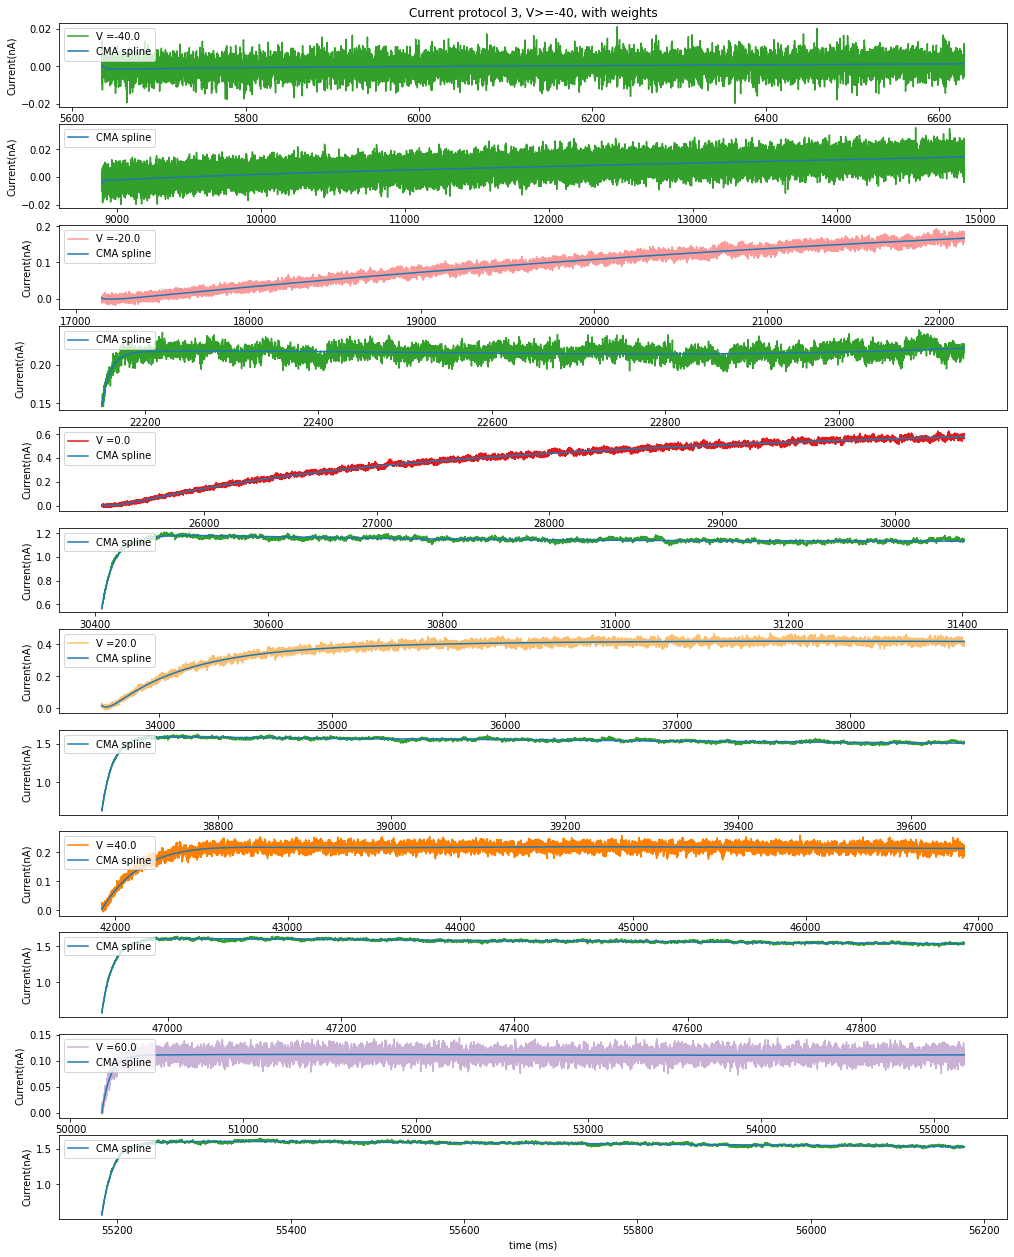

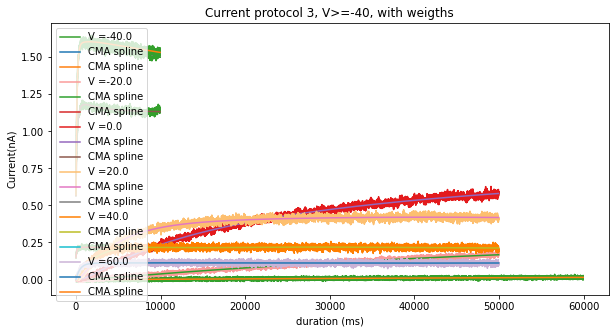

In [87]:
# SKIP THIS CELL IF THE PARAMETERS HAD BEEN SAVED

# CMA_fit with weighting residuals
 
for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    #Inital conditions and constrains:
    if NumExpo_flag:
        p0 = [currents_largerCurrents[index_i][-1], 0.01,times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0], 0.01,(times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0]), 0.01, (times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0])/2, 0.1,1]
        bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]
    else:
        p0 = [splines_largerCurrents[index_i][-1],splines_largerCurrents[index_i][-1] ,times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0] ,0.01 , times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0]]
        bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]

    optscma = cma.CMAOptions()
    optscma.set("bounds", bounds_cma)
    # CMA fit
    es = cma.fmin(SRexpo_spline_weight, p0 , sigma0=1, args=[times_largerCurrents[index_i], deltat_largerCurrents[index_i], currents_largerCurrents[index_i], NumExpo_flag], options = optscma)
    splines_params_largerCurrents_weights[index_i] = es[0]
    splines_largerCurrents_weights[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents_weights[index_i], NumExpo_flag)

# SAVE THE PARAMETERS
np.save('protocol3_cell2_splines_params_largerCurrents_weights.npy',np.array(splines_params_largerCurrents_weights))

fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents_weights[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Current(nA)')
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40, with weights')
axs[index_i].set_xlabel('time (ms)')
plt.show()


plt.figure(figsize=(10, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.plot(splines_largerCurrents_weights[index_i], label = 'CMA spline')
plt.xlabel('duration (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, V>=-40, with weigths')
plt.legend(loc='upper left')
plt.show()

In [23]:
# Save the spline parameters
# np.save('protocol3_cell2_splines_params_largerCurrents_weights.npy',np.array(splines_params_largerCurrents_weights))

# Load the parameters
splines_params_largerCurrents_weights = np.load('protocol3_cell2_splines_params_largerCurrents_weights.npy')

for index_i in range(len(index_largerCurrents)): 
    splines_largerCurrents_weights[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents_weights[index_i], NumExpo_flag)


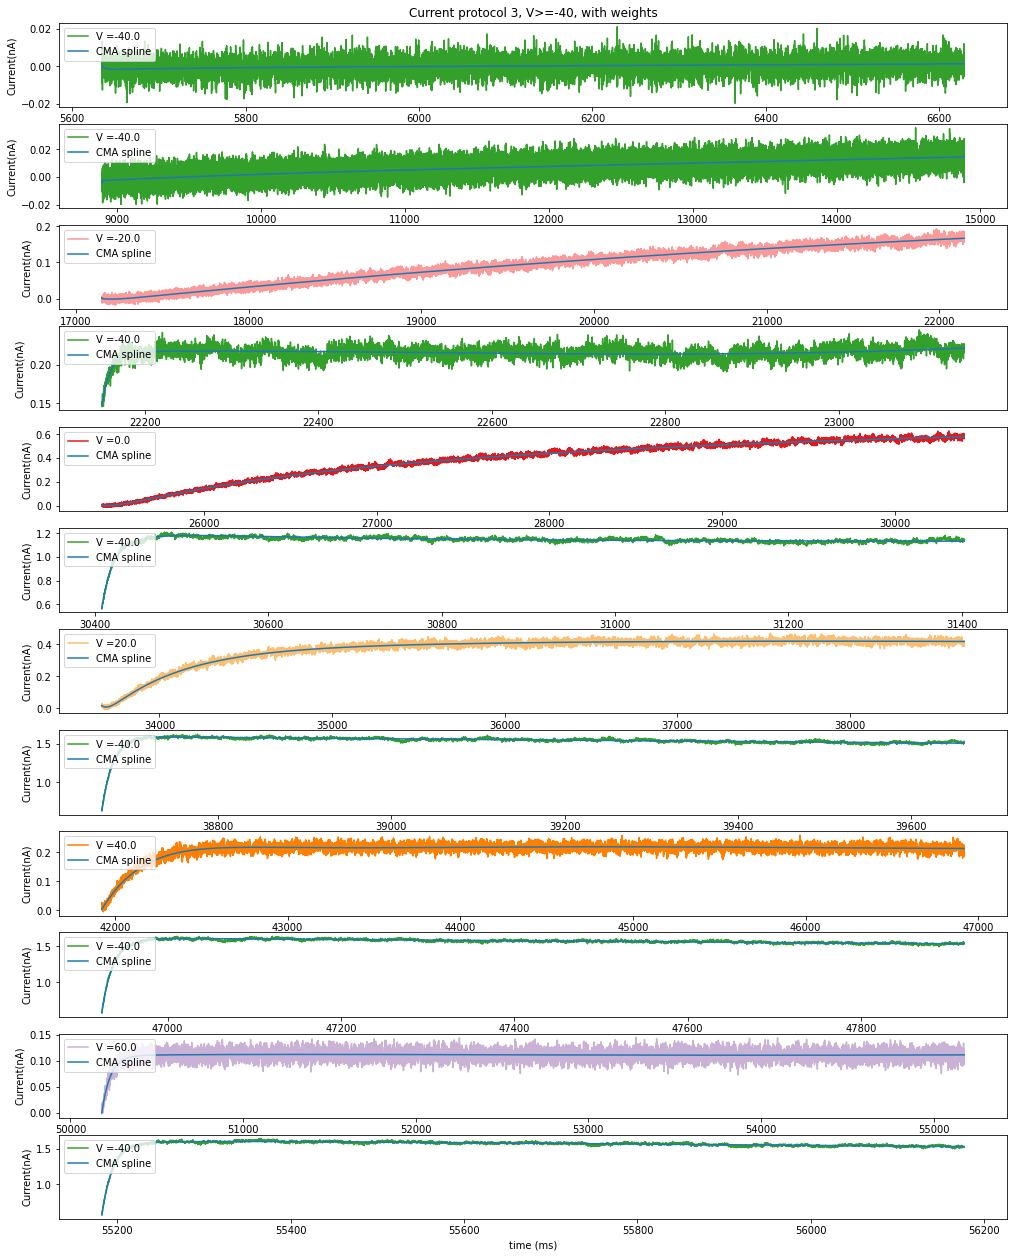

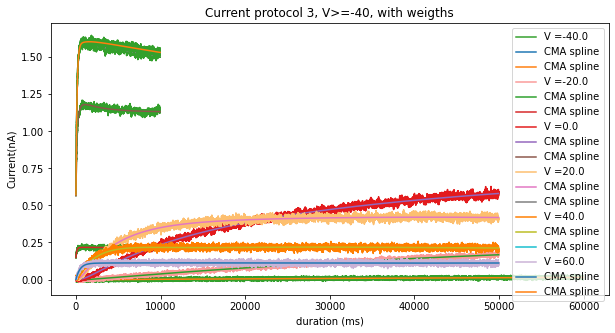

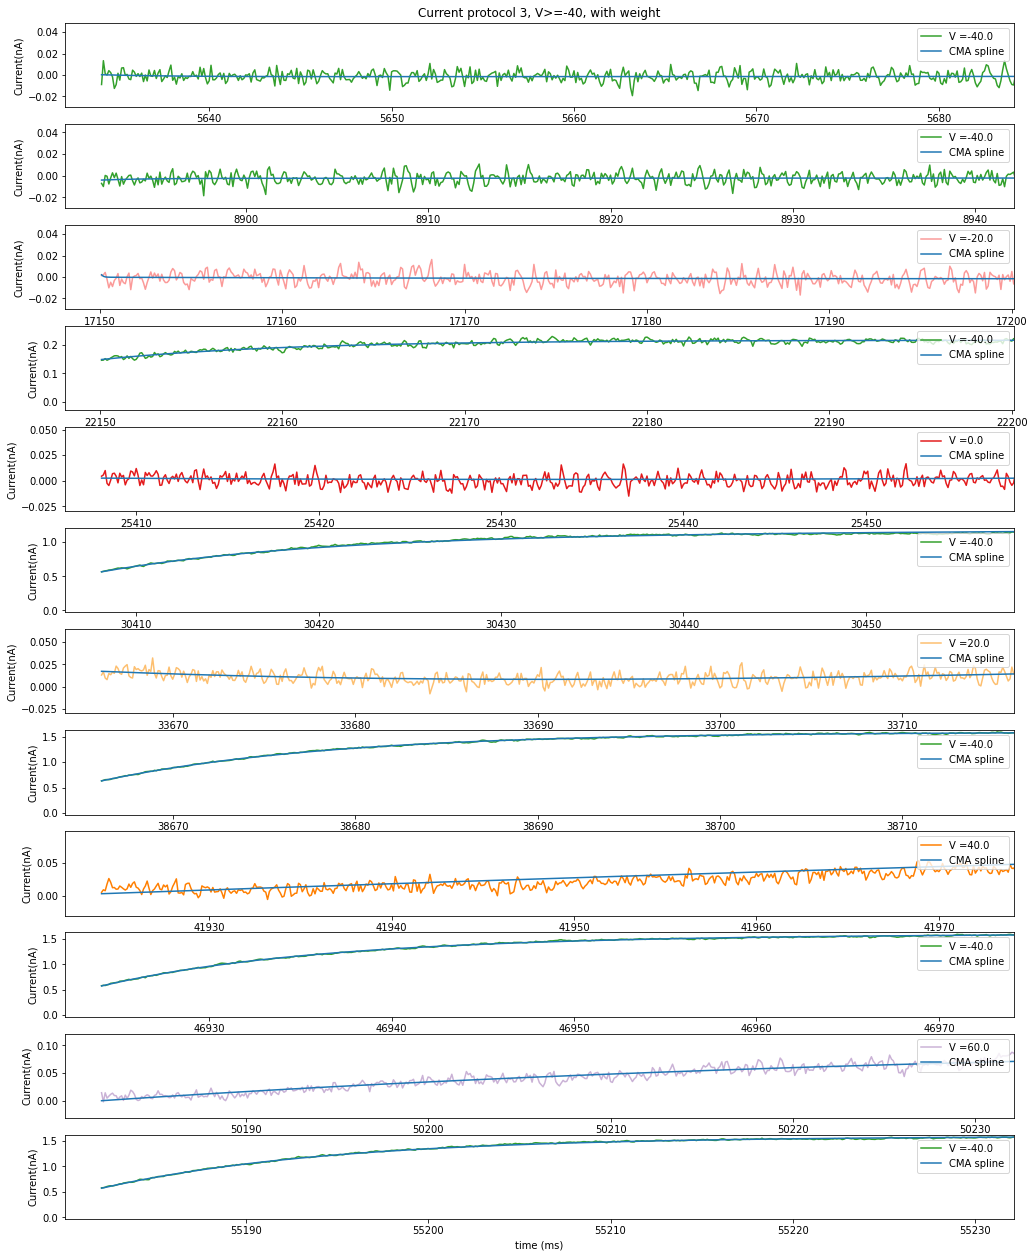

In [24]:
fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents_weights[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Current(nA)')
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40, with weights')
axs[index_i].set_xlabel('time (ms)')
plt.show()


plt.figure(figsize=(10, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.plot(splines_largerCurrents_weights[index_i], label = 'CMA spline')
plt.xlabel('duration (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, V>=-40, with weigths')
plt.legend(loc='upper right')
plt.show()

# Zoom

fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents_weights[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper right')
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].set_xlim([times_largerCurrents[index_i][0]-2,times_largerCurrents[index_i][0]+50])
    axs[index_i].set_ylim([-.03, splines_largerCurrents_weights[index_i][500] + 0.05])
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40, with weight')
axs[index_i].set_xlabel('time (ms)')
plt.show()

## Start analysis of the residuals (noise)

We will use the data with splines AND weights: "spline_..._weights"

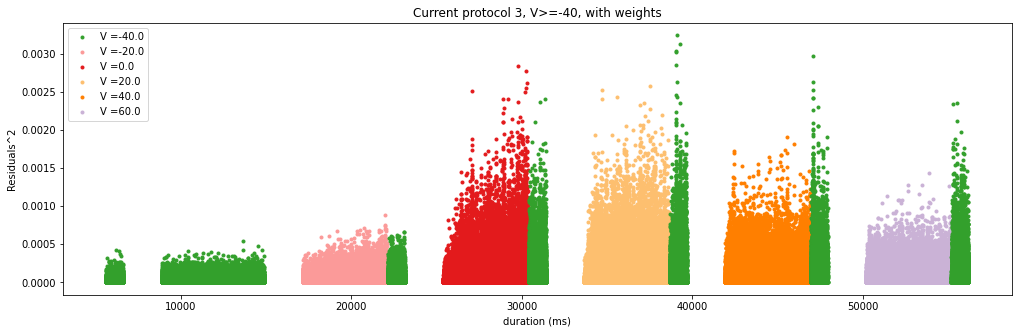

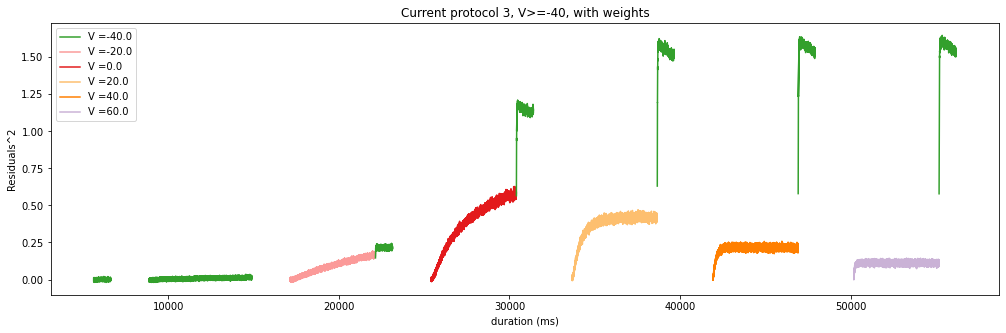

In [34]:
# Residuals

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    residuals = currents_largerCurrents[index_i] - splines_largerCurrents_weights[index_i]
    residuals2_largerCurrents_weights[index_i] = residuals ** 2
    plt.plot(times_largerCurrents[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.title('Current protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Current')
plt.title('Current protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()

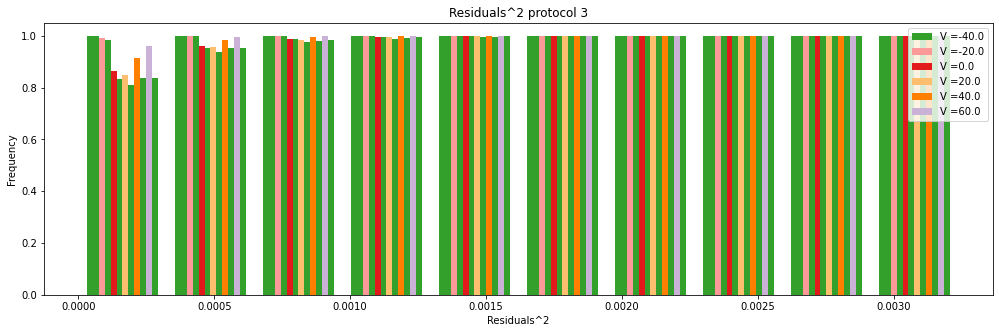

In [122]:
# Histograms of the residuasl
plt.figure(figsize=(17, 5))
plt.hist(residuals2_largerCurrents_weights, bins = 10, density =True, cumulative=True, color = np.array(pr3_voltage_constV_colors)[index_largerCurrents.astype(int)], label=pr3_voltage_constV_labels_simple[index_largerCurrents.astype(int)])
plt.legend(loc='upper right')
plt.xlabel('Residuals^2')
plt.ylabel('Frequency')
plt.title('Residuals^2 protocol 3')

plt.show()

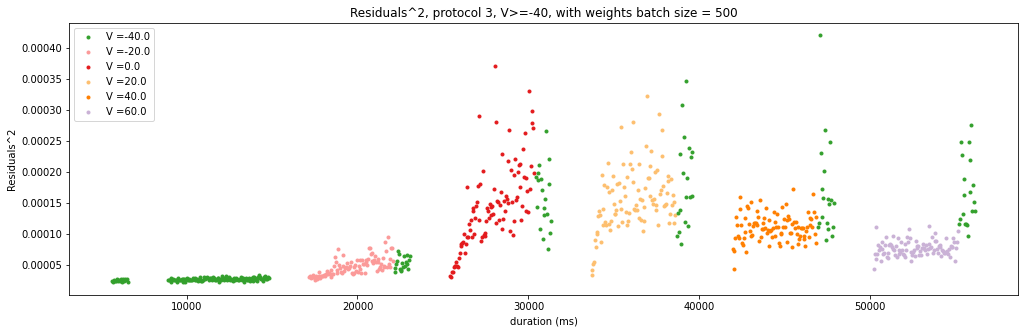

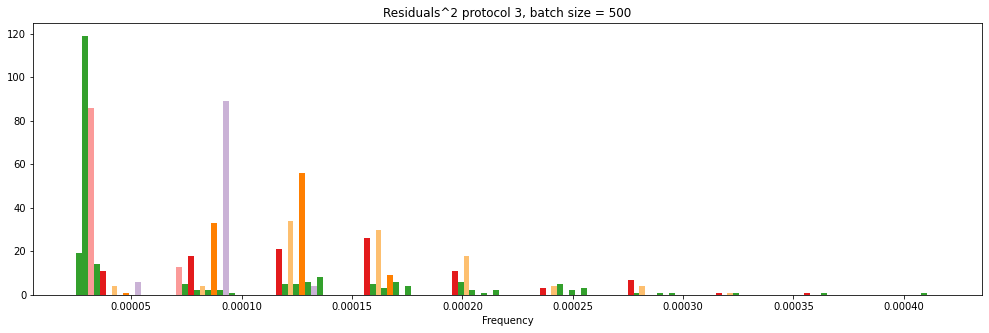

In [112]:
# Take Batch_size time steps and take mean of the residuals, and mean of the spline fit to get a nicer plot
batch_size  = 500
remove_at_end_weights = np.zeros(len(residuals2_largerCurrents_weights)).astype(int)
residuals2_largerCurrents_weights_meanbatch = [None] * len(index_largerCurrents)
times_largerCurrents_weights_meanbatch = [None] * len(index_largerCurrents)
splines_largerCurrents_weights_meanbatch = [None] * len(index_largerCurrents)
currents_largerCurrents_meanbatch = [None] * len(index_largerCurrents)

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    remove_at_end_weights[index_i] = len(residuals2_largerCurrents_weights[index_i])%batch_size
    residuals2_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(residuals2_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    splines_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(splines_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    times_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(times_largerCurrents[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    currents_largerCurrents_meanbatch[index_i] =np.mean(np.reshape(currents_largerCurrents[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    plt.plot(times_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.title('Residuals^2, protocol 3, V>=-40, with weights'+ ' batch size = ' + str(batch_size))
plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(17, 5))
plt.hist(residuals2_largerCurrents_weights_meanbatch,  color = np.array(pr3_voltage_constV_colors)[index_largerCurrents.astype(int)], label=pr3_voltage_constV_labels_simple[index_largerCurrents.astype(int)])
plt.xlabel('Residuals^2 binned')
plt.xlabel('Frequency')
plt.title('Residuals^2 protocol 3, batch size = ' + str(batch_size))
plt.show()




## Scatter plots

Residuals vs: Voltage, Current, and opennes

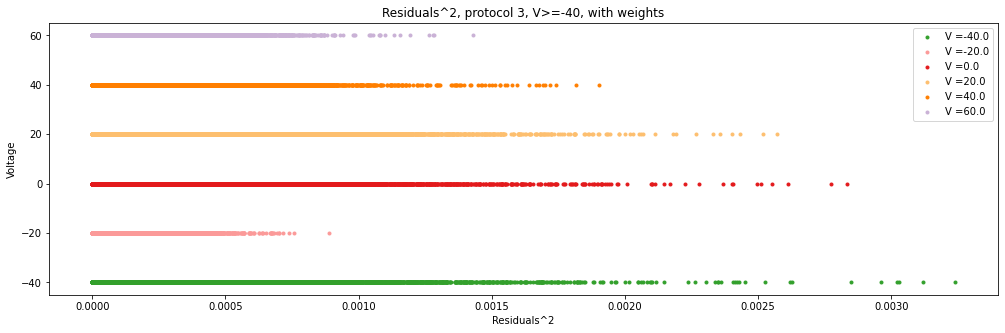

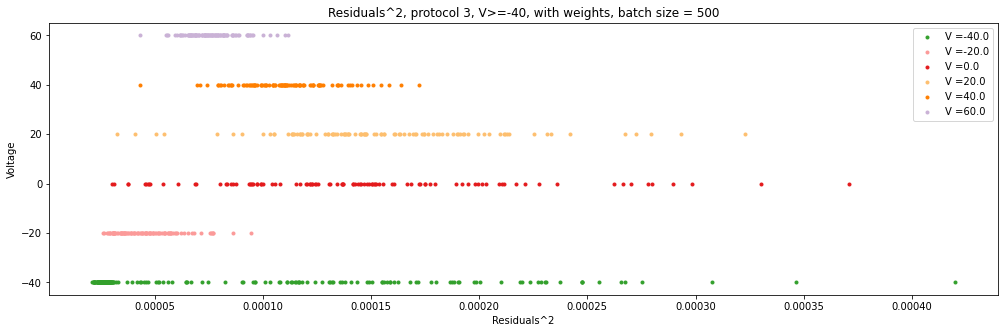

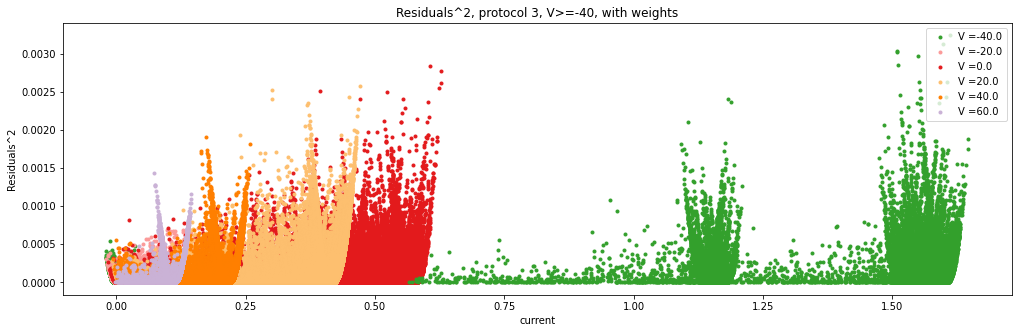

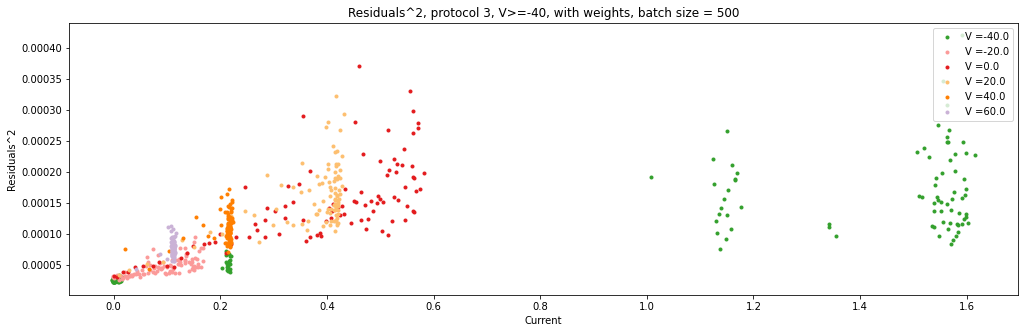

In [116]:
plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot( residuals2_largerCurrents_weights[index_i], pr3_voltage_constV[i]*np.ones(len(residuals2_largerCurrents_weights[index_i])),'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.ylabel('Voltage')
plt.xlabel('Residuals^2')
plt.title('Residuals^2, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(residuals2_largerCurrents_weights_meanbatch[index_i], pr3_voltage_constV[i]*np.ones(len(residuals2_largerCurrents_weights_meanbatch[index_i])), '.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.ylabel('Voltage')
plt.xlabel('Residuals^2')
plt.title('Residuals^2, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()



plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('current')
plt.ylabel('Residuals^2')
plt.title('Residuals^2, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('Current')
plt.ylabel('Residuals^2')
plt.title('Residuals^2, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

## Convert to individual current and openesss

STILL WORK IN PROGRES!!!

In [ ]:
# Single channel parameters
N=76000
Ek = -85
gamma_i = 2e-6# 2 pS -> to uS

V = pr3_voltage[pr3_Vtimes[i]]
indv_current = (V - Ek)*gamma_i # gamma = i/(V - E)

plt.figure(figsize=(14, 5))
plt.scatter(splines_largerCurrents[index_i], residuals2_largerCurrents_weights[index_i])
plt.plot(splines_largerCurrents[index_i], splines_largerCurrents_weights[index_i] * (indv_current - splines_largerCurrents_weights[index_i]/N),'r')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.title('spline val vs Residuals^2 protocol 3, step i='+str(i))
plt.show()

In [ ]:
# With batch size

plt.figure(figsize=(14, 5))
plt.scatter(cma_expo_fit_meanbatch, residuals2_meanbatch)
plt.plot(cma_expo_fit_meanbatch, cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'N '+str(N))
plt.plot(cma_expo_fit_meanbatch, cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/10000), label = 'N = 1000')
plt.plot(cma_expo_fit_meanbatch, epsilon1 + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'toy epsilon, N '+str(N))
plt.plot(cma_expo_fit_meanbatch, epsilon1 + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/10000), label = 'toy epsilon, N = 1000')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.legend(loc='upper left')
plt.title('spline val vs Residuals^2 protocol 3, epsilon1, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]])+ ' batch size = ' + str(batch_size))


plt.figure(figsize=(14, 5))
plt.scatter(cma_expo_fit_meanbatch, residuals2_meanbatch)
plt.plot(cma_expo_fit_meanbatch, cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'No epsilon')
plt.plot(cma_expo_fit_meanbatch, epsilonA + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'epsilonA')
plt.plot(cma_expo_fit_meanbatch, epsilonB + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'epsilonB')
plt.plot(cma_expo_fit_meanbatch, epsilon1 + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'Epsilon1')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.legend(loc='upper left')
plt.title('spline val vs Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]])+ ' batch size = ' + str(batch_size))


plt.show()



## Just to double check: linear regresion:

In [ ]:
x =  cma_expo_fit_meanbatch.reshape(-1,1)
y = residuals2_meanbatch
model_LR = LinearRegression()
model_LR.fit(x, y)
r_sq = model_LR.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model_LR.intercept_)
print('slope:', model_LR.coef_)

print('individual current = ', indv_current)

In [ ]:
plt.figure(figsize=(14, 5))
plt.scatter(cma_expo_fit_meanbatch, residuals2_meanbatch)
plt.plot(cma_expo_fit_meanbatch, cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'No epsilon')
plt.plot(cma_expo_fit_meanbatch, epsilonA + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'epsilonA')
plt.plot(cma_expo_fit_meanbatch, epsilonB + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'epsilonB')
plt.plot(cma_expo_fit_meanbatch, epsilon1 + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'Epsilon1')
plt.plot(cma_expo_fit_meanbatch, model_LR.intercept_ + cma_expo_fit_meanbatch * model_LR.coef_, label = 'LR')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.legend(loc='upper left')
plt.title('spline val vs Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]])+ ' batch size = ' + str(batch_size))


plt.show()

## Generalize for the other V>-40 voltages

### THE FOLLOWING HAS TO BE RE-EDITED!

In [ ]:
index_i = 1


i=index_largerCurrents[index_i]
times_to_skip = 50
V = pr3_voltage[pr3_Vtimes[i]]
indv_current = (V - Ek)*gamma_i # gamma = i/(V - E)

times_neg30[index_i] = pr3_time[(pr3_Vtimes[i]+times_to_skip):(pr3_Vtimes[i+1]-1)]
currents_neg30[index_i] = pr3_current_constV[i][times_to_skip:]
deltat = times_neg30[index_i][0]
three_flag = True

p0 = [0, 0.01,times_neg30[index_i][-1]-times_neg30[index_i][0], 0.01,-(times_neg30[index_i][-1]-times_neg30[index_i][0]), -0.01, -(times_neg30[index_i][-1]-times_neg30[index_i][0])/2 ]

plt.figure(figsize=(14, 5))
plt.plot(pr3_time[(pr3_Vtimes[i]):(pr3_Vtimes[i+1]-1)], pr3_current_constV[i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]))

plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(pr3_time[(pr3_Vtimes[i]+times_to_skip):(pr3_Vtimes[i+1]-1)], pr3_current_constV[i][times_to_skip:],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]))

plt.legend(loc='upper left')
plt.show()


# Let's try with CMA
es = cma.fmin(SRexpo_spline, p0 , sigma0=1, args=[times_neg30[index_i], deltat, currents_neg30[index_i],three_flag])
splines_params_neg30[index_i] = es[0]
splines_neg30[index_i] = expo_spline(times_neg30[index_i], deltat, splines_params_neg30[index_i], three_flag)

plt.figure(figsize=(14, 5))
plt.plot(times_neg30[index_i], currents_neg30[index_i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.plot(times_neg30[index_i], splines_neg30[index_i], label = 'CMA spline')
plt.plot(times_neg30[index_i], expo_spline(times_neg30[index_i], deltat, p0, three_flag), label = 'IC')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, step i='+str(i))
plt.legend(loc='upper left')


plt.show()


# Get residuals
residuals = splines_neg30[index_i] - currents_neg30[index_i]
residuals2_neg30[index_i] = residuals**2

plt.figure(figsize=(14, 5))
plt.scatter(times_neg30[index_i], residuals2_neg30[index_i])
plt.xlabel('time (ms)')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]))


plt.figure()
plt.hist(residuals, bins = 100)
plt.xlabel('Residuals')
plt.xlabel('Frequency')
plt.title('Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]))


plt.figure(figsize=(14, 5))
plt.scatter(splines_neg30[index_i], residuals2_neg30[index_i])
plt.plot(splines_neg30[index_i], splines_neg30[index_i] * (indv_current - splines_neg30[index_i]/N),'r')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.title('spline val vs Residuals^2 protocol 3, step i='+str(i))
plt.show()

plt.show()


In [ ]:
# Take Batch_size time steps and take mean of the residuals, and mean of the spline fit to get a nicer plot
batch_size  = 100

remove_at_end = len(residuals2_neg30[index_i])%batch_size
print(remove_at_end)
residuals2_meanbatch = np.mean(np.reshape(residuals2_neg30[index_i][:-remove_at_end],[-1, batch_size]),axis=1)
cma_expo_fit_meanbatch = np.mean(np.reshape(splines_neg30[index_i][:-remove_at_end],[-1, batch_size]),axis=1)
times_meanbatch = np.mean(np.reshape(times_neg30[index_i][:-remove_at_end],[-1, batch_size]),axis=1)

plt.figure(figsize=(14, 5))
plt.scatter(times_meanbatch, residuals2_meanbatch)
plt.xlabel('time (ms)')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]) + ' batch size = ' + str(batch_size))

plt.figure()
plt.hist(residuals2_meanbatch, bins = 100)
plt.xlabel('Residuals^2 binned')
plt.xlabel('Frequency')
plt.title('Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]) + ' batch size = ' + str(batch_size))


plt.figure(figsize=(14, 5))
plt.scatter(cma_expo_fit_meanbatch, residuals2_meanbatch)
plt.plot(cma_expo_fit_meanbatch, cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'N '+str(N))
plt.plot(cma_expo_fit_meanbatch, cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/10000), label = 'N = 1000')
plt.plot(cma_expo_fit_meanbatch, epsilon1 + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'epsilon1, N '+str(N))
plt.plot(cma_expo_fit_meanbatch, epsilon1 + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/10000), label = 'epsilon1, N = 1000')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.legend(loc='upper left')
plt.title('spline val vs Residuals^2 protocol 3, epsilon1, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]])+ ' batch size = ' + str(batch_size))


plt.figure(figsize=(14, 5))
plt.scatter(cma_expo_fit_meanbatch, residuals2_meanbatch)
plt.plot(cma_expo_fit_meanbatch, cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'No epsilon')
plt.plot(cma_expo_fit_meanbatch, epsilonA + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'epsilonA')
plt.plot(cma_expo_fit_meanbatch, epsilonB + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'epsilonB')
plt.plot(cma_expo_fit_meanbatch, epsilon1 + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'Epsilon1')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.legend(loc='upper left')
plt.title('spline val vs Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]])+ ' batch size = ' + str(batch_size))


plt.show()



## Rest of the protocols

In [ ]:
# Import the data
pr2_time, pr2_voltage, pr2_current = np.loadtxt('Some_Kylies_data/KyliePR2cell123456910.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr4_time, pr4_voltage, pr4_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/cardiac_noise/KylieData/KyliePR4cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr5_time, pr5_voltage, pr5_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR5cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)



# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')
# Load a protocols
protocol_2 = myokit.load_protocol('resources/pr2-activation-kinetics-2.mmt')
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')
protocol_4 = myokit.load_protocol('resources/pr4-inactivation.mmt')
protocol_5 = myokit.load_protocol('resources/pr5-deactivation.mmt')


plt.figure(figsize=(15,4))
plt.title('Cell 5 currents ')
plt.plot(pr2_time, pr2_current, label='Pr2')
plt.plot(pr3_time, pr3_current, label='Pr3')
plt.plot(pr4_time, pr4_current, label='Pr4')
plt.plot(pr5_time, pr5_current, label='Pr5')
plt.xlabel('time (ms)')
plt.ylabel('I (nA)')
plt.legend()


plt.show()


## My testing code

In [ ]:
tmax = 20
dt = .1
deltat = 100
times = np.arange(0, tmax+dt, dt)
params = np.array([10,.001,100,.01,-100, .001,300])
epsi = 0.0001*np.random.randn(len(times))

three_flag = True

x =  expo_spline(times, deltat, params, three_flag)+ epsi
y = SRexpo_spline(params, times, deltat, x, three_flag)


res = minimize(SRexpo_spline, params,args = (times,deltat, x, three_flag), method='Nelder-Mead', tol=1e-6)

params_res = res.x
z =  expo_spline(times, deltat, params_res, three_flag)


plt.plot(times,x, label = 'Data')
plt.plot(times,x-epsi, label = 'True' )
plt.plot(times,z, label = 'Fit')
plt.legend()
plt.show()

print(params_res)
print(params)


In [ ]:
# testing CMA
p0 = params # [0,1,1,.5,1]
es = cma.fmin(SRexpo_spline, params , sigma0=1, args=[times, deltat, x, three_flag])

params_cma = es[0]
score_cma = es[1]


plt.plot(times,x, label = 'Data')
plt.plot(times,x-epsi, label = 'True' )
plt.plot(times,expo_spline(times, deltat, params_cma, three_flag), label = 'Fit')
plt.legend()
plt.show()

print(params_cma)
print(score_cma)

In [ ]:
p0 = [splines_neg30[index_i][-1],splines_neg30[index_i][-1] ,times_neg30[index_i][-1] - times_neg30[index_i][0] ,0.01 , times_neg30[index_i][-1] - times_neg30[index_i][0], 0.1, times_neg30[index_i][0] ]

three_flag = True
if three_flag:
    p0 = [splines_neg30[index_i][-1],splines_neg30[index_i][-1] ,times_neg30[index_i][-1] - times_neg30[index_i][0] ,0.01 , times_neg30[index_i][-1] - times_neg30[index_i][0], 0.1, times_neg30[index_i][0] ]
    bounds_cma = [[0, 0, 0, 0, 0, 0, 0], [None, None, None, None, None, None, None]]
else:
    p0 = [splines_neg30[index_i][-1],splines_neg30[index_i][-1] ,times_neg30[index_i][-1] - times_neg30[index_i][0] ,0.01 , times_neg30[index_i][-1] - times_neg30[index_i][0]]#, 0.1, times_neg30[index_i][0] ]
    bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]

optscma = cma.CMAOptions()
optscma.set("bounds", bounds_cma)
#es = cma.fmin(NBlike_SIR, x0_SIR, sigma0=1, args=(p, parameters_to_optimise_SIR, data_D, travel_data), options = optsSIR)

es = cma.fmin(SRexpo_spline, p0 , sigma0=1, args=[times_neg30[index_i], deltat, currents_neg30[index_i],three_flag], options = optscma)
splines_params_neg30[index_i] = es[0]
splines_neg30[index_i] = expo_spline(times_neg30[index_i], deltat, splines_params_neg30[index_i], three_flag)



plt.figure(figsize=(14, 5))
plt.plot(times_neg30[index_i], currents_neg30[index_i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.plot(times_neg30[index_i], splines_neg30[index_i], label = 'CMA spline')
plt.plot(times_neg30[index_i], expo_spline(times_neg30[index_i], deltat, p0, three_flag), label = 'IC')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, step i='+str(i))
plt.legend(loc='upper left')

plt.show()

In [ ]:
p0 = [splines_neg30[index_i][-1],splines_neg30[index_i][-1] ,times_neg30[index_i][-1] - times_neg30[index_i][0] ,0.01 , times_neg30[index_i][-1] - times_neg30[index_i][0], 0.1, times_neg30[index_i][0] ]

three_flag = True
if three_flag:
    p0 = [splines_neg30[index_i][-1],splines_neg30[index_i][-1] ,times_neg30[index_i][-1] - times_neg30[index_i][0] ,0.01 , times_neg30[index_i][-1] - times_neg30[index_i][0], 0.1, times_neg30[index_i][0], 0.1, times_neg30[index_i][0] ]
    bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]
else:
    p0 = [splines_neg30[index_i][-1],splines_neg30[index_i][-1] ,times_neg30[index_i][-1] - times_neg30[index_i][0] ,0.01 , times_neg30[index_i][-1] - times_neg30[index_i][0]]#, 0.1, times_neg30[index_i][0] ]
    bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]

#p0 = [0.63, 1.4,1788,0.8, 1086]

p0 = [0.63, 1.48*0.88,1628,0.85*0.83, 1277,0.02*0.33,177,0.1,1]

optscma = cma.CMAOptions()
optscma.set("bounds", bounds_cma)
#optscma.set('tolfun', 1e-12)

#es = cma.fmin(SRexpo_spline, p0 , sigma0=1, args=[times_neg30[index_i], deltat, currents_neg30[index_i],three_flag], options = optscma)
#splines_params_neg30[index_i] = es[0]
#splines_neg30[index_i] = expo_spline(times_neg30[index_i], deltat, splines_params_neg30[index_i], three_flag)



plt.figure(figsize=(14, 5))
plt.plot(times_neg30[index_i], currents_neg30[index_i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.plot(times_neg30[index_i], splines_neg30[index_i], label = 'CMA spline')
#plt.plot(times_neg30[index_i], expo_spline(times_neg30[index_i], deltat, p0, three_flag), label = 'IC')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, step i='+str(i))
plt.legend(loc='upper left')

plt.show()

In [ ]:
x = np.arange(0, 40, 0.1)
y = np.ones(len(x))
w = 1 / (1 + 9*(x>1) + 90 * (x>10))
print(w)

In [ ]:
index_i = 2
i=index_largerCurrents[index_i]

# Testing definitions
#res = currents_neg30[index_i] - splines_neg30[index_i]
#res2 = res**2
w  = 1 / (1 + 9*((times_neg30[index_i]-deltat_neg30[index_i])>10) + 90*((times_neg30[index_i]-deltat_neg30[index_i])>100) + 900*((times_neg30[index_i]-deltat_neg30[index_i])>1000))



plt.figure(figsize=(14, 5))
plt.plot(times_neg30[index_i], res2,'-', label='R^2 V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.plot(times_neg30[index_i], w*res2,'.', label='w*R^2 V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.xlabel('time (ms)')
plt.ylabel('residuals')
plt.title('Current protocol 3, step i='+str(i))
plt.legend(loc='upper left')
plt.show()


p0 = [currents_neg30[index_i][-1], 0.01,times_neg30[index_i][-1]-times_neg30[index_i][0], 0.01,(times_neg30[index_i][-1]-times_neg30[index_i][0]), 0.01, (times_neg30[index_i][-1]-times_neg30[index_i][0])/2, 0.1,1]
bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]

optscma = cma.CMAOptions()
optscma.set("bounds", bounds_cma)
    # CMA fit
es = cma.fmin(SRexpo_spline_weight, p0 , sigma0=1, args=[times_neg30[index_i], deltat_neg30[index_i], currents_neg30[index_i], NumExpo_flag], options = optscma)
s_neg30_W_test = expo_spline(times_neg30[index_i], deltat_neg30[index_i], es[0], NumExpo_flag)

plt.figure(figsize=(14, 5))
plt.plot(times_neg30[index_i], currents_neg30[index_i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
#plt.plot(times_neg30[index_i], splines_neg30[index_i], label = 'CMA spline')
plt.plot(times_neg30[index_i], s_neg30_W_test, label = 'CMA spline + W')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, step i='+str(i))
plt.legend(loc='upper left')

plt.show()